In [1]:
import os
import sys

if "COLAB_GPU" in os.environ:
  from google.colab import drive
  print("Hello, Colab")
  drive.mount("/content/drive")
  ROOT_PATH = "/content/drive/MyDrive/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
elif "PAPERSPACE_CLUSTER_ID" in os.environ:
  print("Hello, Paperspace")
  ROOT_PATH = "/notebooks/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
else:
  ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))

EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/tcnn-abilities"
ARTIFACTS_PATH = f"{EXPERIMENT_PATH}/artifacts"
sys.path.insert(0, ROOT_PATH)

Hello, Paperspace


In [2]:
# !pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 15.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 67.6 MB/s eta 0:00:00:00:0100:01


In [ ]:
from collections import defaultdict
from json import load, dumps, dump

from tqdm import tqdm
import heapq
import random
import pandas as pd
import numpy as np
# import umap
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from src.utils import get_logical_plan, get_full_plan, get_selectivities
from src.models import binary_tree_layers as btl
from src.datasets.oracle import Oracle, OracleRequest, TIMEOUT
from src.datasets.data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET
from src.datasets.data_types import ExplainNode
from src.datasets.vectorization import extract_vertices_and_edges, ALL_FEATURES
from src.datasets.binary_tree_dataset import binary_tree_collate, BinaryTreeDataset, WeightedBinaryTreeDataset, weighted_binary_tree_collate, paddify_sequences

In [4]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from scipy.interpolate import Rbf
from mpl_toolkits.mplot3d import Axes3D

# Loading data

## Oracles

In [5]:
job_oracle = Oracle(f"{ROOT_PATH}/data/processed/JOB")
sq_oracle = Oracle(f"{ROOT_PATH}/data/processed/sample_queries")

## `list_info`s

In [6]:
job_list_info = torch.load(f"{ARTIFACTS_PATH}/job_list_info")
ood_sq_list_info = torch.load(f"{ARTIFACTS_PATH}/ood_sq_list_info")
id_sq_list_info = torch.load(f"{ARTIFACTS_PATH}/id_sq_list_info")

In [7]:
job_list_vertices, job_list_edges, job_list_time = [[info[key] for info in job_list_info] for key in ["vertices", "edges", "time"]]        
ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time = [[info[key] for info in ood_sq_list_info] for key in ["vertices", "edges", "time"]]
id_sq_list_vertices, id_sq_list_edges, id_sq_list_time = [[info[key] for info in id_sq_list_info] for key in ["vertices", "edges", "time"]]

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {DEVICE}")

device is cuda


In [9]:
# it'll be splitted correctly on train/val datasets` in `load_run`
trainval_dataset = WeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE)

test_dataset = WeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE)
ood_dataset = WeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, id_sq_list_time, DEVICE)

## Model and datasets

We'll use in that notebook as a model the most successful architecture - Big TCNN with Instance Normalization.

In [10]:
in_channels = len(ALL_FEATURES)
max_length = max([v.shape[0] for v in job_list_vertices + ood_sq_list_vertices + id_sq_list_vertices])
batch_size = 256
lr = 3e-4

In [11]:
def load_ckpt(model, ckpt_path):
    ckpt_state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt_state['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(ckpt_state['optimizer_state_dict'])
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    scheduler.load_state_dict(ckpt_state['scheduler_state_dict'])
    start_epoch = ckpt_state["epoch"]    
    return model, optimizer, scheduler, start_epoch

In [12]:
class BinaryTreeRegressor(nn.Module):
    def __init__(self, btcnn: "btl.BinaryTreeSequential", fcnn: "torch.nn.Sequential", name: "str" = "unknown"):
        super().__init__()
        self.btcnn: "btl.BinaryTreeSequential" = btcnn
        self.fcnn: "torch.nn.Sequential" = fcnn
        self.name: "str" = name

    def forward(self, vertices: "Tensor", edges: "Tensor") -> "Tensor":
        return self.fcnn(self.btcnn(vertices=vertices, edges=edges))

In [13]:
big_btcnn_and_instance_norm = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeInstanceNorm(128),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeInstanceNorm(256),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

In [14]:
def load_run(run):
    generator = torch.Generator().manual_seed(42+run-1)
    train_dataset, val_dataset = torch.utils.data.dataset.random_split(trainval_dataset, [0.8, 0.2], generator=generator)
    train_dataloader, val_dataloader = [
        DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=lambda el: weighted_binary_tree_collate(el, max_length),
            drop_last=False
        )
        for dataset in [train_dataset, val_dataset]
    ] 

    model, optimizer, scheduler, start_epoch = load_ckpt(
        model=BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn()),
        ckpt_path=f"{EXPERIMENT_PATH}/models/BigBTCNN_BigFCNN_InstanceNorm_{run}.pth",
    )
    model = model.to(DEVICE)
    return model, train_dataset, val_dataset, train_dataloader, val_dataloader

In [15]:
def get_mse(model, dataset):
    with torch.no_grad():
        running_loss, total_samples = .0, 0
        for v, e, f, t in tqdm(dataset):
            v, e = preprocess(v, e)               
            running_loss += f.to("cpu") * ((model(v.unsqueeze(0), e.unsqueeze(0)).squeeze(0) - t).to("cpu") ** 2).float()
            total_samples += f.to("cpu")
    return (running_loss / total_samples).item() if total_samples else .0

# Helpers

## Data processing

In [16]:
def preprocess(v, e):
    """unifies tensors from dataset with tensors from dataloader; see `weighted_binary_tree_collate`"""
    v, e = v.clone(), e.clone()
    v = torch.stack(paddify_sequences([v], max_length)).transpose(1, 2)[0]
    e = torch.stack(paddify_sequences([e], max_length)).unsqueeze(1)[0]
    return v, e

In [17]:
def get_structure(v, e):
    """cleans cards (and selectivities) and returns hashable repr"""
    scale = 10 ** 3
    v = v.clone()
    v = torch.round(v * scale) / scale
    v[-2:,:] = 0
    return str(v.flatten().tolist()), str(e.flatten().tolist())

In [18]:
def get_tree(v, e):
    """returns hashable repr for v, e"""
    v = v.clone()
    return str(v.flatten().tolist()), str(e.flatten().tolist())

In [19]:
def featurize_dataset(dataset, model, train_structures, train_trees, data_type):
    df = pd.DataFrame(list(dataset), columns=["vertices", "edges", "frequency", "time"])
    df["data_type"] = data_type

    df["time_category"] = "small"
    df.loc[df["time"] > 0.2, "time_category"] = "medium"
    df.loc[df["time"] > 4, "time_category"] = "big"

    df["structure"] = df.apply(lambda row: get_structure(*preprocess(row["vertices"], row["edges"])), axis=1)
    df["structure_category"] = "unseen"
    df.loc[df["structure"].isin(train_structures), "structure_category"] = "seen"

    df["tree"] = df.apply(lambda row: get_tree(*preprocess(row["vertices"], row["edges"])), axis=1)
    df["tree_category"] = "unseen"
    df.loc[df["tree"].isin(train_trees), "tree_category"] = "seen"

    with torch.no_grad():
        df["embedding"] = df.apply(lambda row: model.btcnn(*[t.unsqueeze(0) for t in preprocess(row["vertices"], row["edges"])]).squeeze(0).to("cpu"), axis=1)
        df["prediction"] = df.apply(lambda row: model(*[t.unsqueeze(0) for t in preprocess(row["vertices"], row["edges"])]).to("cpu"), axis=1)        

    for col in ["prediction", "frequency", "time"]:
        df[col] = df.apply(lambda row: row[col].item(), axis=1)

    df["error"] = df["prediction"] - df["time"]
    df["prediction_category"] = "underestimated"
    df.loc[df["error"] > 0, "prediction_category"] = "overestimated"
    
    return df

In [20]:
def filter_df(df, data_type_predicate, structure_predicate="all", tree_predicate="all", time_predicate="all", prediction_predicate="all"):
    idx = (df["data_type"] == data_type_predicate)
    if structure_predicate != "all":
        idx = idx & (df["structure_category"] == structure_predicate)
    if tree_predicate != "all":
        idx = idx & (df["tree_category"] == tree_predicate)        
    if time_predicate != "all":
        idx = idx & (df["time_category"] == time_predicate)
    if prediction_predicate != "all":
        idx = idx & (df["prediction_category"] == prediction_predicate)
    return df.loc[idx]

In [21]:
def load_run_and_get_filtered_df(run, data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate):
    model, train_dataset, val_dataset, train_dataloader, val_dataloader = load_run(run)
    train_structures = {get_structure(*preprocess(v, e)) for v, e, *_ in train_dataset}
    train_trees = {get_tree(*preprocess(v, e)) for v, e, *_ in train_dataset}
    datasets = (
        featurize_dataset(dataset, model, train_structures, train_trees, data_type) 
        for dataset, data_type in zip([train_dataset, val_dataset, test_dataset, ood_dataset], ["train", "val", "test", "ood"])
    )
    df = pd.concat(datasets, ignore_index=True)
    return filter_df(df, data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate)

### Small debug - loading the learned model

In [22]:
model, train_dataset, val_dataset, train_dataloader, val_dataloader = load_run(1)
print(f"Expected train loss is ~0.06939, real one is {get_mse(model, train_dataset):0.4f}")
print(f"Expected val loss is 27.72444, real one is {get_mse(model, val_dataset):0.4f}")
print("It seems that model loading is sucessfully finished! ")

100%|██████████| 5859/5859 [00:11<00:00, 513.19it/s]


Expected train loss is ~0.06939, real one is 0.0657


100%|██████████| 1464/1464 [00:01<00:00, 863.74it/s]

Expected val loss is 27.72444, real one is 27.7198
It seems that model loading is sucessfully finished! 


## Building $\langle$ `vertices`, `edges`$\rangle$ $\rightarrow$ `query_info` map

In [160]:
TRAIN_VE_TO_TIMES = defaultdict(set)
TRAIN_VET_TO_QUERY_INFO = defaultdict(set)

for info in job_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)

    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    TRAIN_VE_TO_TIMES[ve].add(t)

    vet = str(v.flatten().tolist()), str(e.flatten().tolist()), str(t.flatten().tolist())
    TRAIN_VET_TO_QUERY_INFO[vet].add((info["query_name"], info["hintset"], info["dop"]))

In [536]:
OOD_VE_TO_TIMES = defaultdict(set)
OOD_VET_TO_QUERY_INFO = defaultdict(set)

for info in ood_sq_list_info:
    v, e, t = info["vertices"], info["edges"], info["time"]
    v, e = preprocess(v, e)

    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    OOD_VE_TO_TIMES[ve].add(t)

    vet = str(v.flatten().tolist()), str(e.flatten().tolist()), str(t.flatten().tolist())
    OOD_VET_TO_QUERY_INFO[vet].add((info["query_name"], info["hintset"], info["dop"]))

In [161]:
def get_query_info(v, e, ve_map, vet_map, oracle):
    ve = str(v.flatten().tolist()), str(e.flatten().tolist())
    assert ve in ve_map
    res = []
    for t in set(ve_map[ve]):
        vet = str(v.flatten().tolist()), str(e.flatten().tolist()), str(t.flatten().tolist())
        for q_n, hs, dop in vet_map[vet]:
            res.append((q_n, hs, dop, oracle.get_execution_time(OracleRequest(query_name=q_n, hintset=hs, dop=dop))))
    return res

In [25]:
def is_dirty(v, e):
    return TIMEOUT in [t for *_, t in get_query_info(v, e, TRAIN_VE_TO_TIMES, TRAIN_VET_TO_QUERY_INFO, job_oracle)]

## Neighborhoods extracting

In [26]:
def get_neighborhoods(v, e, target_d, debug=False):
    """collects `target_d`-neighborhoods - list its subtrees of height `target_d`"""
    neighborhoods = []

    def recurse(root, cur_d):
        ngbs = [root]
        real_d = -float("inf")
        if cur_d == target_d:
            return 0, ngbs
        for child_d, child_ngbs in [recurse(child.item()-1, cur_d+1) for child in e[root][1:] if child]:
            ngbs += child_ngbs
            real_d = max(real_d, child_d)
        return real_d + 1, ngbs

    neighborhoods = [ngbs for i in range(len(v)) for (max_d, ngbs) in [recurse(i, 0)] if max_d == target_d]
    
    if debug:
        return neighborhoods

    return [torch.stack([v[i] for i in l if i]) for l in neighborhoods]

In [27]:
def get_proportions_of_subtree_matches(dataset, subtrees_height, seen_subtrees):
    matches = []
    for v, e, f, t in dataset:
        per_v_matches = []
        for ngb in get_neighborhoods(v, e, subtrees_height):
            per_v_matches.append(str(ngb.detach().to("cpu").tolist()) in seen_subtrees)
        matches.append(per_v_matches)
    return matches

### Example.

**Tree (with taking into account the padding vertex)**
```python3
                     1                      
                     |                      
                     2                      
                    /  \                 
                   3   17               
                  / \                       
                 4  16                      
                / \  
               5  15                            
              / \                               
             /   \
            /     \                                  
           6       13                                 
          / \       |                                
         7  12     14                               
        / \                                          
       8  11                                       
      / \                                     
     9  10       
```

In [28]:
print("Edges in example tree:")
for p, c1, c2 in job_list_edges[0]:
    if c1 and c2:
        print(f"{p.item()} -> [{c1.item()}, {c2.item()}]")
    elif c1:
        print(f"{p.item()} -> [{c1.item()}]")
    elif c2:
        print(f"{p.item()} -> [{c2.item()}]")

Edges in example tree:
1 -> [2]
2 -> [3, 17]
3 -> [4, 16]
4 -> [5, 15]
5 -> [6, 13]
6 -> [7, 12]
7 -> [8, 11]
8 -> [9, 10]
13 -> [14]


In [29]:
print("Expected results: the only  difference is that there's no 0\nReal results:")
for edge, ngbs in list(zip([x.tolist() for x in job_list_edges[0]], get_neighborhoods(job_list_vertices[0], job_list_edges[0], 1, debug=True)))[:5]:
    print(f"{[el +1 for el in ngbs]} vs {edge}")
print("It works")

Expected results: the only  difference is that there's no 0
Real results:
[1, 2] vs [1, 2, 0]
[2, 3, 17] vs [2, 3, 17]
[3, 4, 16] vs [3, 4, 16]
[4, 5, 15] vs [4, 5, 15]
[5, 6, 13] vs [5, 6, 13]
It works


In [30]:
childs = defaultdict(list)
for parent, child1, child2 in job_list_edges[0]:
    if child1:
        childs[parent.item()-1].append(child1.item()-1)
    if child2:
        childs[parent.item()-1].append(child2.item()-1)        
        
for ngbs_1d, ngbs_2d in list(zip(get_neighborhoods(job_list_vertices[0], job_list_edges[0], 1, debug=True), get_neighborhoods(job_list_vertices[0], job_list_edges[0], 2, debug=True)))[:5]:
    print(f"{[el+1 for el in ngbs_1d]} -> {[el + 1 for el in ngbs_2d]}")
print("Thank God it's working too...")

[1, 2] -> [1, 2, 3, 17]
[2, 3, 17] -> [2, 3, 4, 16, 17]
[3, 4, 16] -> [3, 4, 5, 15, 16]
[4, 5, 15] -> [4, 5, 6, 13, 15]
[5, 6, 13] -> [5, 6, 7, 12, 13, 14]
Thank God it's working too...


### Calculating

In [31]:
def calculate_neighborhoods_dict(n_runs=5):
    res = defaultdict(list)
    for run in range(1, n_runs+1):
        _, train_dataset, val_dataset, *_ = load_run(run)
        for d in range(1, 5):
            train_subtrees = set()
            for v, e, f, t in train_dataset:
                for ngb in get_neighborhoods(v, e, d):
                    subtree = str(ngb.detach().to("cpu").tolist())
                    train_subtrees.add(subtree)

            val_l = get_proportions_of_subtree_matches(val_dataset, d, train_subtrees)
            val_l = [int(el) for subl in val_l for el in subl]
            res[(d, "train")].append(val_l)

            test_l = get_proportions_of_subtree_matches(test_dataset, d, train_subtrees)
            test_l = [int(el) for subl in test_l for el in subl]
            res[(d, "test")].append(test_l)

    return res

In [32]:
def aggregate_neighborhoods_dict(neighborhoods_dict, runs_range, save=True):
    pm = u"\u00B1"
    aggregated_neighborhoods_list = []
    
    for key in neighborhoods_dict:
        val = neighborhoods_dict[key]
        aggregated_neighborhoods_list.append((*key, f"{np.mean([np.mean(val[i-1]) for i in runs_range]):0.3f}{pm}{np.std([np.mean(val[i-1]) for i in runs_range]):0.3f}"))
    aggregated_neighborhoods_df = pd.DataFrame(aggregated_neighborhoods_list, columns=["height", "data_type", "match_probability"])
    
    if save:
        aggregated_neighborhoods_df.to_csv(f"{ARTIFACTS_PATH}/aggregated_neighborhoods_df.csv", index=False)
    
    return aggregated_neighborhoods_df

In [33]:
# neighborhoods_dict = calculate_neighborhoods_dict(5)
# aggregated_neighborhoods_df = aggregate_neighborhoods_dict(neighborhoods_dict, runs_range=range(1, 5+1), save=True)
aggregated_neighborhoods_df = pd.read_csv(f"{ARTIFACTS_PATH}/aggregated_neighborhoods_df.csv")

## Stratified metrics 

In [34]:
def calculate_stratified_metrics(n_runs=5):
    res = defaultdict(list)

    for run in range(1, n_runs+1):
        model, train_dataset, val_dataset, train_dataloader, val_dataloader = load_run(run)
        train_structures = {get_structure(*preprocess(v, e)) for v, e, *_ in train_dataset}
        train_trees = {get_tree(*preprocess(v, e)) for v, e, *_ in train_dataset}
        
        datasets = (
            featurize_dataset(dataset, model, train_structures, train_trees, data_type) 
            for dataset, data_type in zip([train_dataset, val_dataset, test_dataset, ood_dataset], ["train", "val", "test", "ood"])
        )
        df = pd.concat(datasets, ignore_index=True)
        
        for data_type_predicate in ["train", "val", "test", "ood"]:
            for structure_predicate in ["all", "seen", "unseen"]:
                for tree_predicate in ["all", "seen", "unseen"]:
                    for time_predicate in ["all", "small", "medium", "big"]:
                        for prediction_predicate in ["all", "underestimated", "overestimated"]:
                            filtered_df = filter_df(df, data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate)
                            size = int(filtered_df["frequency"].sum())
                            mse = float((((filtered_df["prediction"] - filtered_df["time"]) ** 2) * filtered_df["frequency"]).sum() / size) if size else .0
                            mape = float((((filtered_df["prediction"] - filtered_df["time"]).abs() / filtered_df["time"]) * filtered_df["frequency"]).sum() / size) if size else .0
                            res[(data_type_predicate, structure_predicate, tree_predicate, time_predicate, prediction_predicate)].append((size, mse, mape))
                            
    return res

In [35]:
def aggregate_metrics_dict(metrics_dict, runs_range, save=True):
    pm = u"\u00B1"
    aggregated_metrics_list = []
    for key in metrics_dict:
        val = metrics_dict[key]
        aggregated_metrics_list.append(
            (
                *key,
                f"{np.mean([val[i-1][0] for i in runs_range]):0.0f}",
                f"{np.mean([val[i-1][1] for i in runs_range]):0.3f}{pm}{np.std([val[i-1][1] for i in runs_range]):0.3f}", 
                f"{np.mean([val[i-1][2] for i in runs_range]):0.3f}{pm}{np.std([val[i-1][2] for i in runs_range]):0.3f}",
            )
        )
    aggregated_metrics_df = pd.DataFrame(
        aggregated_metrics_list, 
        columns=["data_type", "structure_category", "tree_category", "time_category", "prediction_category", "size", "mse", "mape"]
    )
    if save:
        aggregated_metrics_df.to_csv(f"{ARTIFACTS_PATH}/aggregated_metrics_df.csv", index=False)
    return aggregated_metrics_df

In [36]:
def filter_metrics_df(df, allowed_data_type_predicates=None, allowed_structure_predicates=None, allowed_tree_predicates=None, allowed_time_predicates=None, allowed_prediction_predicates=None):
    if allowed_data_type_predicates is None:
        allowed_data_type_predicates = ["train", "val", "test", "ood"]
    if allowed_structure_predicates is None:
        allowed_structure_predicates = ["seen", "unseen", "all"]        
    if allowed_tree_predicates is None:
        allowed_tree_predicates = ["seen", "unseen", "all"]                
    if allowed_time_predicates is None:
        allowed_time_predicates = ["big", "medium", "small", "all"]                
    if allowed_prediction_predicates is None:
        allowed_prediction_predicates = ["underestimated", "overestimated", "all"]                

    idx = (df["data_type"].isin(allowed_data_type_predicates))
    idx = idx & (df["structure_category"].isin(allowed_structure_predicates))
    idx = idx & (df["tree_category"].isin(allowed_tree_predicates))
    idx = idx & (df["time_category"].isin(allowed_time_predicates))
    idx = idx & (df["prediction_category"].isin(allowed_prediction_predicates))

    return df[idx]

In [500]:
# metrics_dict = calculate_stratified_metrics(5)
# aggregated_metrics_df = aggregate_metrics_dict(metrics_dict, range(1, 5+1), True)
aggregated_metrics_df = pd.read_csv(f"{ARTIFACTS_PATH}/aggregated_metrics_df.csv")

## Plots

In [38]:
def plot_avg_knn_times(support_points):
    all_t, all_f = 0, 0
    res = []
    for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0]):
        all_f += f
        all_t += f * t
        res.append(all_t / all_f)
    plt.figure(figsize=(10, 4))
    plt.plot(res, marker='o', linestyle='-', color='b')
    plt.title("Average times over top-k neighbors")
    plt.xlabel("k")
    plt.ylabel("Average time")
    plt.grid(True) 
    plt.show() 

In [39]:
def get_k_support_points_and_all_distances(target_embedding, points_dataloader, k):
    top_k = []
    target_embedding = target_embedding.to(DEVICE)
    with torch.no_grad():
        all_distances = []
        for (vertices_batch, edges_batch, f_batch), t_batch in tqdm(points_dataloader):    
            embeddings = model.btcnn(vertices_batch.to(DEVICE), edges_batch.to(DEVICE))
            predicts = model(vertices_batch, edges_batch).squeeze(0)
            distances = torch.cdist(target_embedding.unsqueeze(0), embeddings, p=2).squeeze(0) / torch.norm(target_embedding)
            
            for i in range(predicts.size(0)):
                distance = distances[i].item()
                embedding = embeddings[i]
                all_distances.append(distance)
                v, e, f, t, predict = vertices_batch[i], edges_batch[i], f_batch[i].item(), t_batch[i].item(), predicts[i].item()
                
                # id is here to avoid problems with comparing tensors
                heapq.heappush(top_k, (-distance, id(v), v.to("cpu"), e.to("cpu"), f, t, predict, embedding))
                while len(top_k) > k:
                    heapq.heappop(top_k)
                    
    return [(-d, v, e, f, t, p, emb) for (d, t_id, v, e, f, t, p, emb) in top_k], all_distances

In [40]:
def prepare_args_for_3d_plot(idx, interesting_subdf, n_support_points=100, neighborhoods_size=50, noise_level=0.1):
    target_v, target_e, target_embedding, target_y = interesting_subdf.loc[idx][["vertices", "edges", "embedding", "time"]]

    support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=n_support_points)
    main_X = [emb.to("cpu") for *_, emb in support_points]
    main_y = [t for *_, t, p, emb in support_points]

    all_auxilary_X, all_auxilary_y = [], []
    for d, v, e, *_ in support_points:
        for noise_level_ in [noise_level/10, noise_level, noise_level*10]:
            # data from dataloader is already preprocessed
            auxilary_X, auxilary_y = get_close_embeddings(v, e, model, neighborhoods_size, noise_level_, do_preprocess=False)
            all_auxilary_X += auxilary_X
            all_auxilary_y += auxilary_y

    for noise_level_ in [noise_level/10, noise_level, noise_level*10]:
        auxilary_X, auxilary_y = get_close_embeddings(target_v, target_e, model, neighborhoods_size, noise_level_)
        all_auxilary_X += auxilary_X
        all_auxilary_y += auxilary_y
        
    return main_X, main_y, target_embedding, target_y, all_auxilary_X, all_auxilary_y

In [278]:
def plot_3d_surface(
    main_x, main_y, target_x, target_y, auxilary_x, auxilary_y, title, 
    path=None, elev=0, azim=0, softplus_rescale=False, with_auxilary_points=False, projector=umap.UMAP
    ):
    projector = projector(n_components=2)
    projector.fit(torch.stack(main_x).numpy())
    all_X_2d = projector.transform(torch.stack(main_x + auxilary_x).numpy())
    
    if softplus_rescale:
        main_y = np.log(np.exp(main_y)-1).tolist()
        target_y = np.log(np.exp(target_y)-1)
        auxilary_y = np.log(np.exp(auxilary_y)-1).tolist()

    all_y = main_y + auxilary_y
    main_X_2d = projector.transform(torch.stack(main_x).numpy())
    auxilary_X_2d = projector.transform(torch.stack(auxilary_x).numpy())
    target_x_2d = projector.transform(torch.stack([target_x]).numpy())[0]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams['text.usetex'] = False
    
    rbf = Rbf(all_X_2d[:, 0], all_X_2d[:, 1], all_y, function='linear')
    x_ = np.linspace(np.min(all_X_2d[:,0]), np.max(all_X_2d[:,0]), 100)
    y_ = np.linspace(np.min(all_X_2d[:,1]), np.max(all_X_2d[:,1]), 100)
    X_grid, Y_grid = np.meshgrid(x_, y_)
    Z_grid = rbf(X_grid, Y_grid)
    
    if with_auxilary_points:
        ax.scatter(auxilary_X_2d[:,0], auxilary_X_2d[:, 1], auxilary_y, color='black', s=1, marker='.', label='Auxilary Point', zorder=10, alpha=0.7)
    
    ax.scatter(main_X_2d[:,0], main_X_2d[:, 1], main_y, color='black', s=50, label='Main Point', marker='.', alpha=1, zorder=-2)
    ax.scatter(target_x_2d[0], target_x_2d[1], target_y, color='red', s=100, marker='o', label='Target Point', zorder=10000, alpha=1, edgecolors='r')
    #ax.plot([target_x_2d[0], target_x_2d[0]], [target_x_2d[1], target_x_2d[1]], [0, target_y], color='red', linestyle='-', linewidth=1, zorder=500, alpha=1)

    surface = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', edgecolor='none', alpha=0.7, zorder=1)
    cbar = fig.colorbar(surface, ax=ax, shrink=1, aspect=20)
    cbar.set_label('Function Value')

    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Prediction')
    ax.set_title(title)

    if path:
        plt.savefig(path, bbox_inches="tight", dpi=300)
        
    ax.view_init(elev=elev, azim=azim)
    plt.show() 

In [42]:
def get_close_embeddings(v, e, model, n=100, noise_level=0.1, do_preprocess=True):
    v, e = preprocess(v, e) if do_preprocess else (v, e)
    v, e, model = v.to("cpu"), e.to("cpu"), model.to("cpu")

    noise = 1 + (torch.randn(n, *v.shape) * noise_level)
    noised_v = noise * v
    noised_e = e.unsqueeze(0).expand((n, -1, -1, -1))
    noised_predictions = model(noised_v, noised_e)
    noised_embeddings = model.btcnn(noised_v, noised_e)
    
    model.to(DEVICE)
    return [emb.detach() for emb in noised_embeddings], [el.item() for el in noised_predictions]

In [569]:
def plot_times(train_times, test_times, val_times, ood_times):
    fontsize = 16
    plt.rcParams.update({'font.size': fontsize})
    fig, axs = plt.subplots(4, 1, figsize=(30, 16), sharex=True, sharey=True, constrained_layout=True)

    axs[0].set_xscale('log')
    sns.histplot(train_times, kde=True, ax=axs[0], color='blue')
    axs[0].set_title('TRAIN')
    axs[0].set_xlabel('Value', fontsize=fontsize+3)
    axs[0].set_ylabel('Frequency', fontsize=fontsize+3)
    axs[0].tick_params(axis='x', which='both', labelbottom=True)

    axs[1].set_xscale('log')
    sns.histplot(val_times, kde=True, ax=axs[1], color='green')
    axs[1].set_title('VAL')
    axs[1].set_xlabel('Value', fontsize=fontsize+3)
    axs[1].set_ylabel('Frequency', fontsize=fontsize+3)
    axs[1].tick_params(axis='x', which='both', labelbottom=True)

    axs[2].set_xscale('log')
    sns.histplot(test_times, kde=True, ax=axs[2], color='red')
    axs[2].set_title('TEST')
    axs[2].set_xlabel('Value', fontsize=fontsize+3)
    axs[2].set_ylabel('Frequency', fontsize=fontsize+3)
    axs[2].tick_params(axis='x', which='both', labelbottom=True)

    axs[3].set_xscale('log')
    sns.histplot(ood_times, kde=True, ax=axs[3], color='purple')
    axs[3].set_title('OOD times')
    axs[3].set_xlabel('Value', fontsize=fontsize+3)
    axs[3].set_ylabel('Frequency', fontsize=fontsize+3)
    axs[3].tick_params(axis='x', which='both', labelbottom=True, labelsize=fontsize+3)

    plt.show()

# Observations and statements

Here we'll form statements around the question
<center><i>"What is the key to generalising knowledge through a BTCNN?".</i></center>

## Train data

Here we will study the NN errors in the simplest case - on the training data.

**Observation:** all `train` data has been learned (at least memorized), but we have high `MAPE` on small queries due to overestimations, i.e. on `train` data relative error of NN's predictions may still be high.

In [45]:
filter_metrics_df(
    df=aggregated_metrics_df, 
    allowed_data_type_predicates=["train"], 
    allowed_structure_predicates=["seen"], 
    allowed_tree_predicates=["seen"],
    allowed_time_predicates=["small"],
    allowed_prediction_predicates=None,
)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
51,train,seen,seen,small,all,8725,0.017±0.000,56.244±0.000
52,train,seen,seen,small,underestimated,2084,0.003±0.000,0.367±0.000
53,train,seen,seen,small,overestimated,6641,0.022±0.000,73.779±0.000


### Statement #1: `TIMEOUT` lead to underestimation of the **label**, which complicates the landscape

For queries with `TIMEOUT`s, the label actually stops to reflect the actual dependency, and as a result the learned landscape could become *much more complex*. Indeed, if many long queries have similar plans but the baselines of their timeout values are very different, the NN will have to adjust for this.

In [194]:
train_df = load_run_and_get_filtered_df(1, "train", "all", "all", "all", "all")

In [195]:
train_df["abs_error"] = train_df["error"].abs()
train_df["mape"] = train_df["prediction"] / train_df["time"] .abs()
train_df["is_dirty"] = train_df.apply(lambda row: is_dirty(*preprocess(row["vertices"], row["edges"])), axis=1)

In [196]:
train_df.loc[
    ((train_df["prediction_category"] == "overestimated") & (train_df["is_dirty"] == True)),
    ["mape", "time", "prediction", "frequency", "time_category", "is_dirty", "abs_error"],
].sort_values(by=["mape"], ascending=False).head()

,mape,time,prediction,frequency,time_category,is_dirty,abs_error
5177,7746.332418,0.001176,9.109687,4,small,True,9.108511
4571,947.625568,0.001176,1.114408,2,small,True,1.113232
2654,826.094399,0.000510,0.421308,2,small,True,0.420798
3149,765.558284,0.000740,0.566513,2,small,True,0.565773
1356,717.227377,0.000604,0.433205,2,small,True,0.432601


In [197]:
TIMEOUTED_AND_OVERESTIMATED_IDX = 5177
target_v, target_e, target_embedding, target_y = train_df.loc[TIMEOUTED_AND_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")

100%|██████████| 23/23 [00:01<00:00, 21.86it/s]

distance 0.000 | real time 0.001 | prediction 9.113 | is_dirty=True
distance 0.121 | real time 5.847 | prediction 7.258 | is_dirty=False
distance 0.125 | real time 9.867 | prediction 6.071 | is_dirty=False
distance 0.125 | real time 14.105 | prediction 12.363 | is_dirty=True
distance 0.149 | real time 7.265 | prediction 7.187 | is_dirty=False
distance 0.160 | real time 9.139 | prediction 5.807 | is_dirty=False
distance 0.167 | real time 5.131 | prediction 7.192 | is_dirty=False
distance 0.178 | real time 4.610 | prediction 4.959 | is_dirty=False
distance 0.187 | real time 5.492 | prediction 6.126 | is_dirty=False
distance 0.194 | real time 5.155 | prediction 5.092 | is_dirty=False


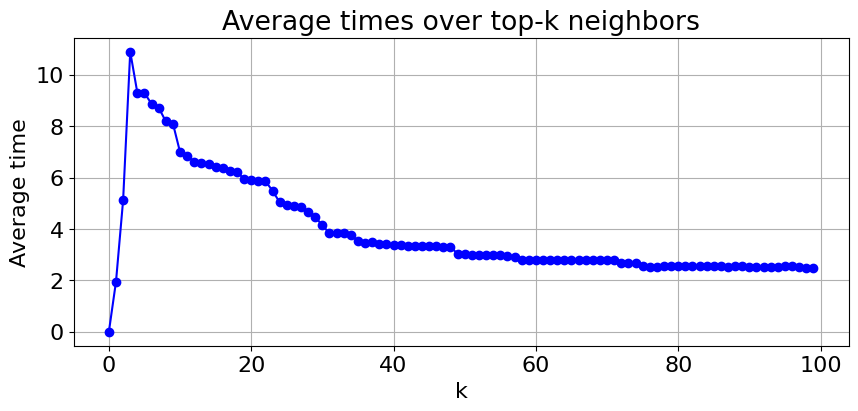

In [50]:
plot_avg_knn_times(support_points)

In [199]:
TIMEOUTED_AND_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    TIMEOUTED_AND_OVERESTIMATED_IDX, train_df, 20, 100, noise_level=.1
)

100%|██████████| 23/23 [00:01<00:00, 21.21it/s]


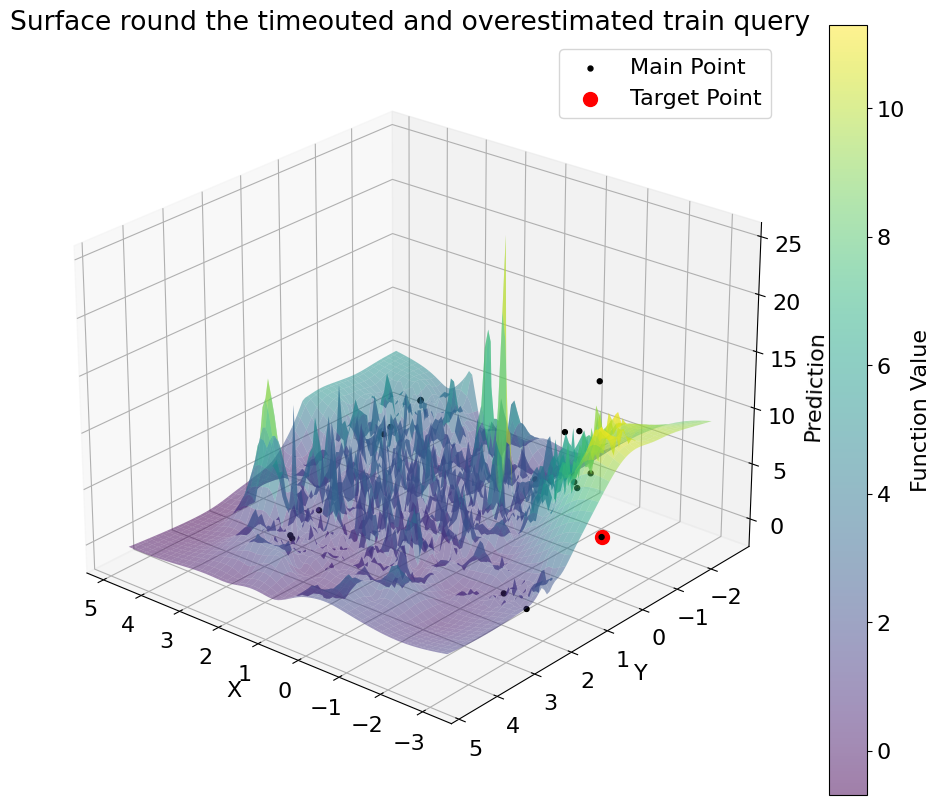

In [200]:
plot_3d_surface(
    *TIMEOUTED_AND_OVERESTIMATED_ARGS, 
    "Surface round the timeouted and overestimated train query",  None, 25, 130, softplus_rescale=False, with_auxilary_points=False, projector=PCA
)

In [201]:
print("Queries and parameters that lead to target plan (query, hs, dop):")
[(q_n, hs, dop) for q_n, hs, dop, t in get_query_info(*preprocess(target_v, target_e), TRAIN_VE_TO_TIMES, TRAIN_VET_TO_QUERY_INFO, job_oracle)]

Queries and parameters that lead to target plan (query, hs, dop):


[('30c', 120, 1), ('30c', 56, 1), ('30c', 124, 1), ('30c', 60, 1)]

In [202]:
print(f"Execution time of default plan is ~{job_oracle.get_execution_time(OracleRequest(query_name='30c', hintset=0, dop=1)) / 1000:0.3f} sec")

Execution time of default plan is ~0.001 sec


Note that the actual execution time for this query is ~14sec. This means that our processning `TIMEOUTS` indeed led to underestimation of the label and this, in turn, created the situation above - next to the large labels we plan with a highly underestimated time. In fact, we can even say that overestimating such a label is a natural behaviour - because other similar queries clearly show that certain patterns from the plan are signals of slow performance.

### Statement #2: in some regions the landscape is sharp by the nature of the task

The very nature of the dependence under study may cause situations when fast queries are located with relatively long queries, which makes the task of approximating surface difficult.
In the extreme case where plans are completely same, we called this phenomenon *collision*. Although we have already simplified the problem in `WeightedDataset` by handling all collisions, a weaker version of this phenomenon is still observed in the data - we have **similar plans** whose labels are **significantly different**.

#### overestimation of non-`TIMEOUT`ed plan

In [203]:
train_df.loc[
    ((train_df["prediction_category"] == "overestimated") & (train_df["is_dirty"] == False)),
    ["mape", "time", "prediction", "frequency", "time_category", "is_dirty", "abs_error"],
].sort_values(by=["mape"], ascending=False).head()

,mape,time,prediction,frequency,time_category,is_dirty,abs_error
3417,1710.742480,0.000611,1.045264,2,small,False,1.044653
1819,1039.990263,0.000882,0.917271,2,small,False,0.916389
655,978.014939,0.000752,0.735467,4,small,False,0.734715
5205,967.154942,0.000446,0.431351,4,small,False,0.430905
595,956.817030,0.000796,0.761626,2,small,False,0.760830


In [231]:
MOST_OVERESTIMATED_IDX = 3417
target_v, target_e, target_embedding, target_y = train_df.loc[MOST_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")

100%|██████████| 23/23 [00:01<00:00, 21.48it/s]

distance 0.000 | real time 0.001 | prediction 1.044 | is_dirty=False
distance 0.080 | real time 1.626 | prediction 0.859 | is_dirty=False
distance 0.204 | real time 9.867 | prediction 6.071 | is_dirty=False
distance 0.212 | real time 4.610 | prediction 4.959 | is_dirty=False
distance 0.214 | real time 5.847 | prediction 7.258 | is_dirty=False
distance 0.214 | real time 7.265 | prediction 7.187 | is_dirty=False
distance 0.218 | real time 5.131 | prediction 7.192 | is_dirty=False
distance 0.226 | real time 0.001 | prediction 9.113 | is_dirty=True
distance 0.229 | real time 0.000 | prediction 0.148 | is_dirty=False
distance 0.233 | real time 5.492 | prediction 6.126 | is_dirty=False


We see, that there's **a lot** of *conflicts* where close points have different times. Probably, that makes approximation harder.

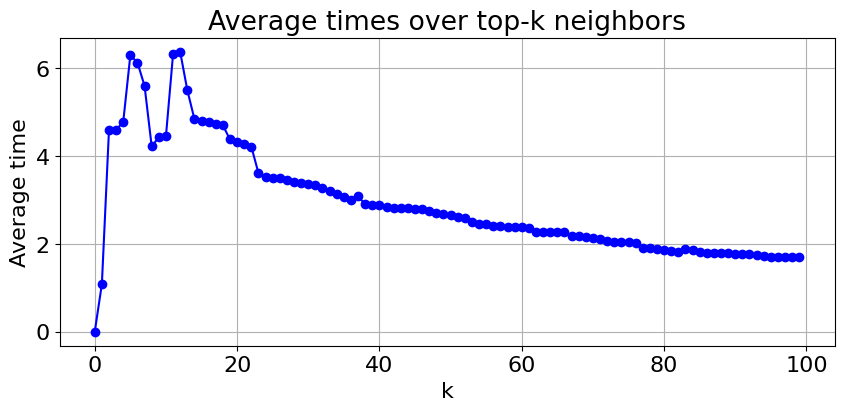

In [249]:
plot_avg_knn_times(support_points)

In [348]:
MOST_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    MOST_OVERESTIMATED_IDX, train_df, 10, 10, noise_level=1
)

100%|██████████| 23/23 [00:01<00:00, 21.54it/s]


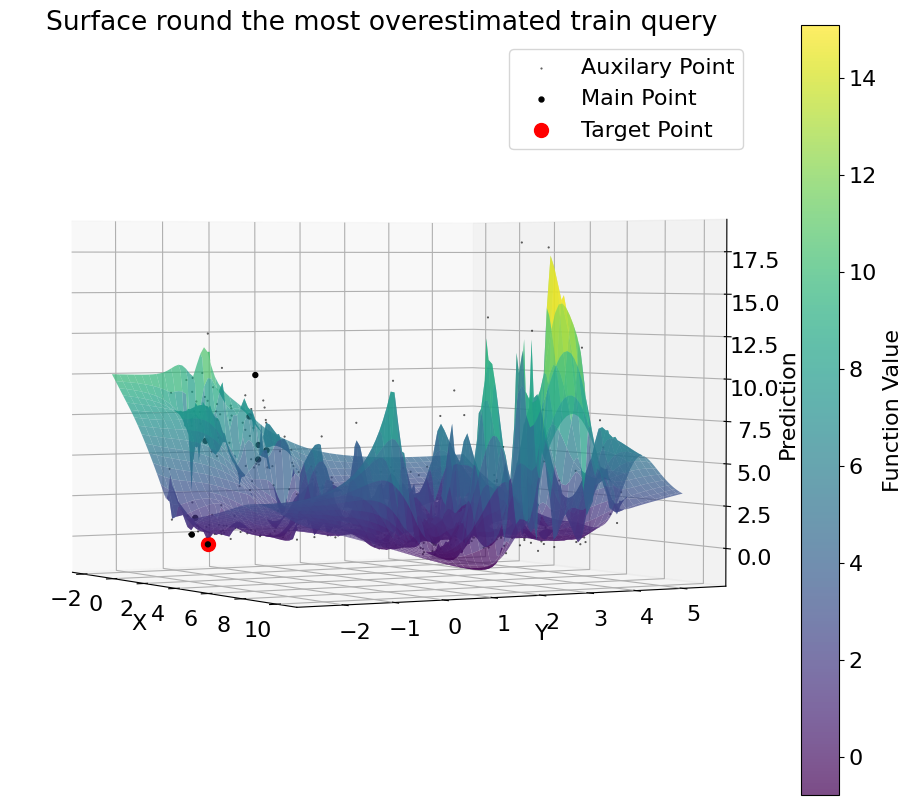

In [362]:
plot_3d_surface(
    *MOST_OVERESTIMATED_ARGS, 
    "Surface round the most overestimated train query",  None, 2, -30, softplus_rescale=False, with_auxilary_points=True, projector=PCA
)

Everything appears as though the smoothness of the surface approximated by NN leads to a situation where points on the slopes of a sharp peak are underestimated in order to “catch up” and approach a sufficiently small value at its base. And due to the struggle of three forces - a) needing a sufficiently large value at the peak, b) not too small on the slope, b) and very small at the elevation, we end up with *underestimation* and *overestimation* in the latter two cases, respectively.

### Statement #3: the sharpness of landscape makes learning dynamic harder

We also ran training on fully noisy data, where independently generated noise for each plan was fed instead of tree structure and statistics. 

Notation:
- `[all]` - fully noised data
- `[ops]` - data with noise istead of tree structure
- `[stats]` - data with noise istead of node's cardinalities and selectivities

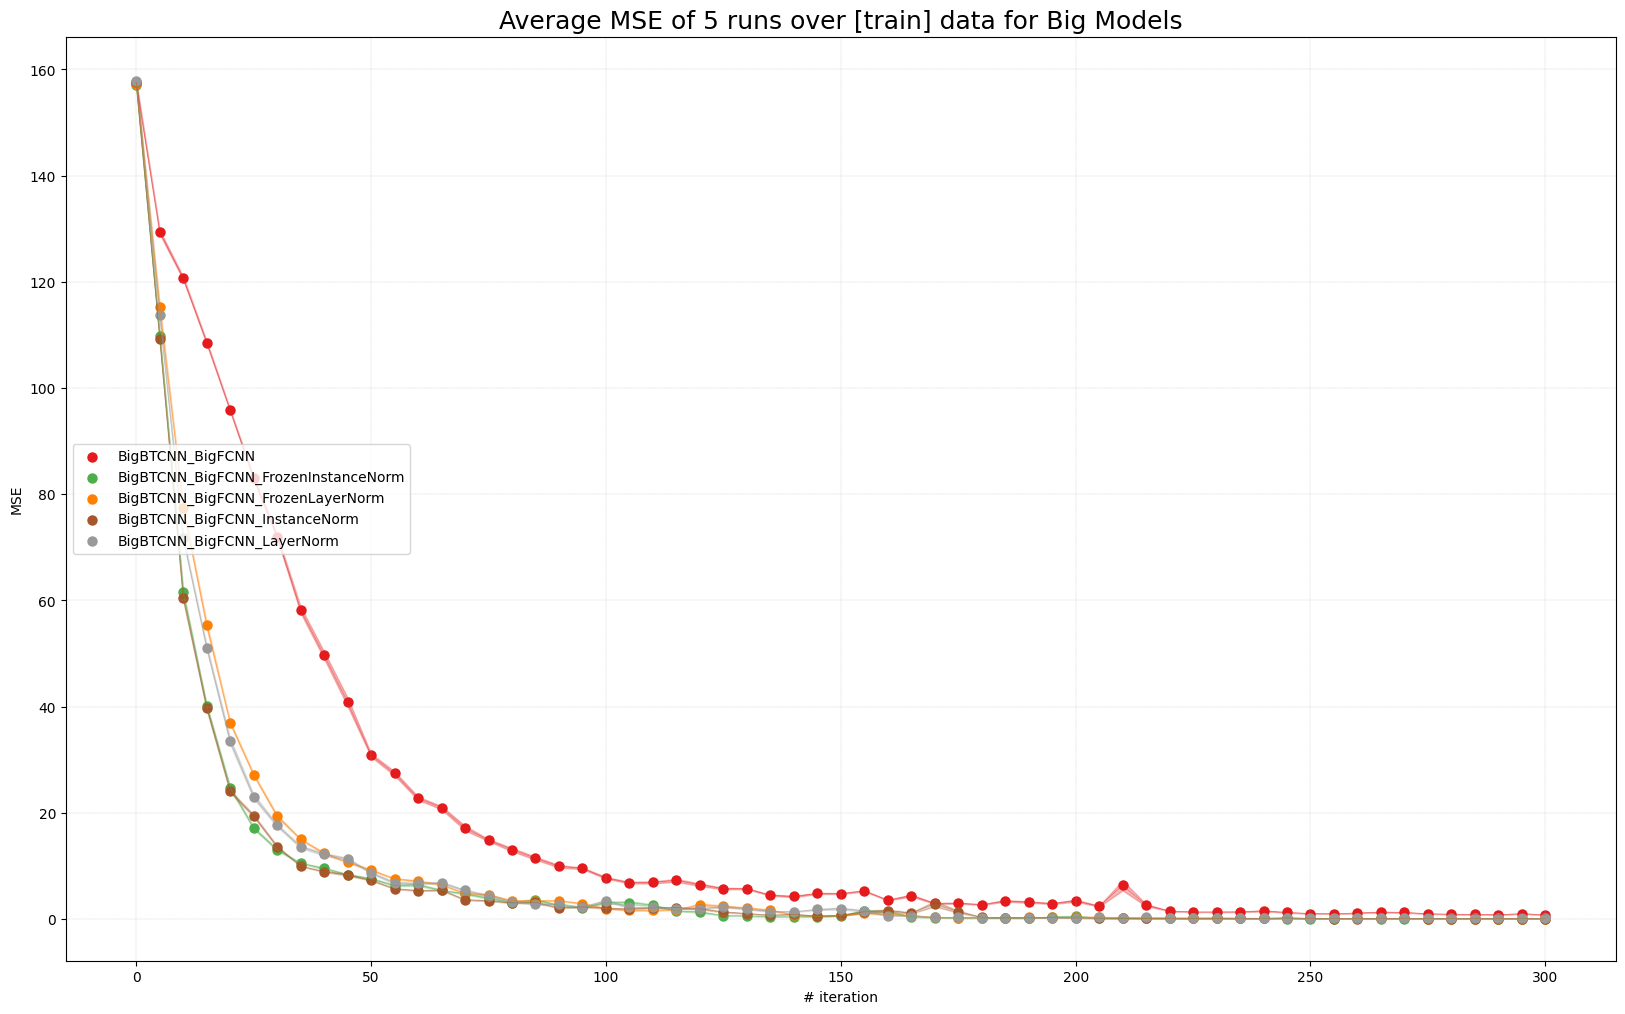

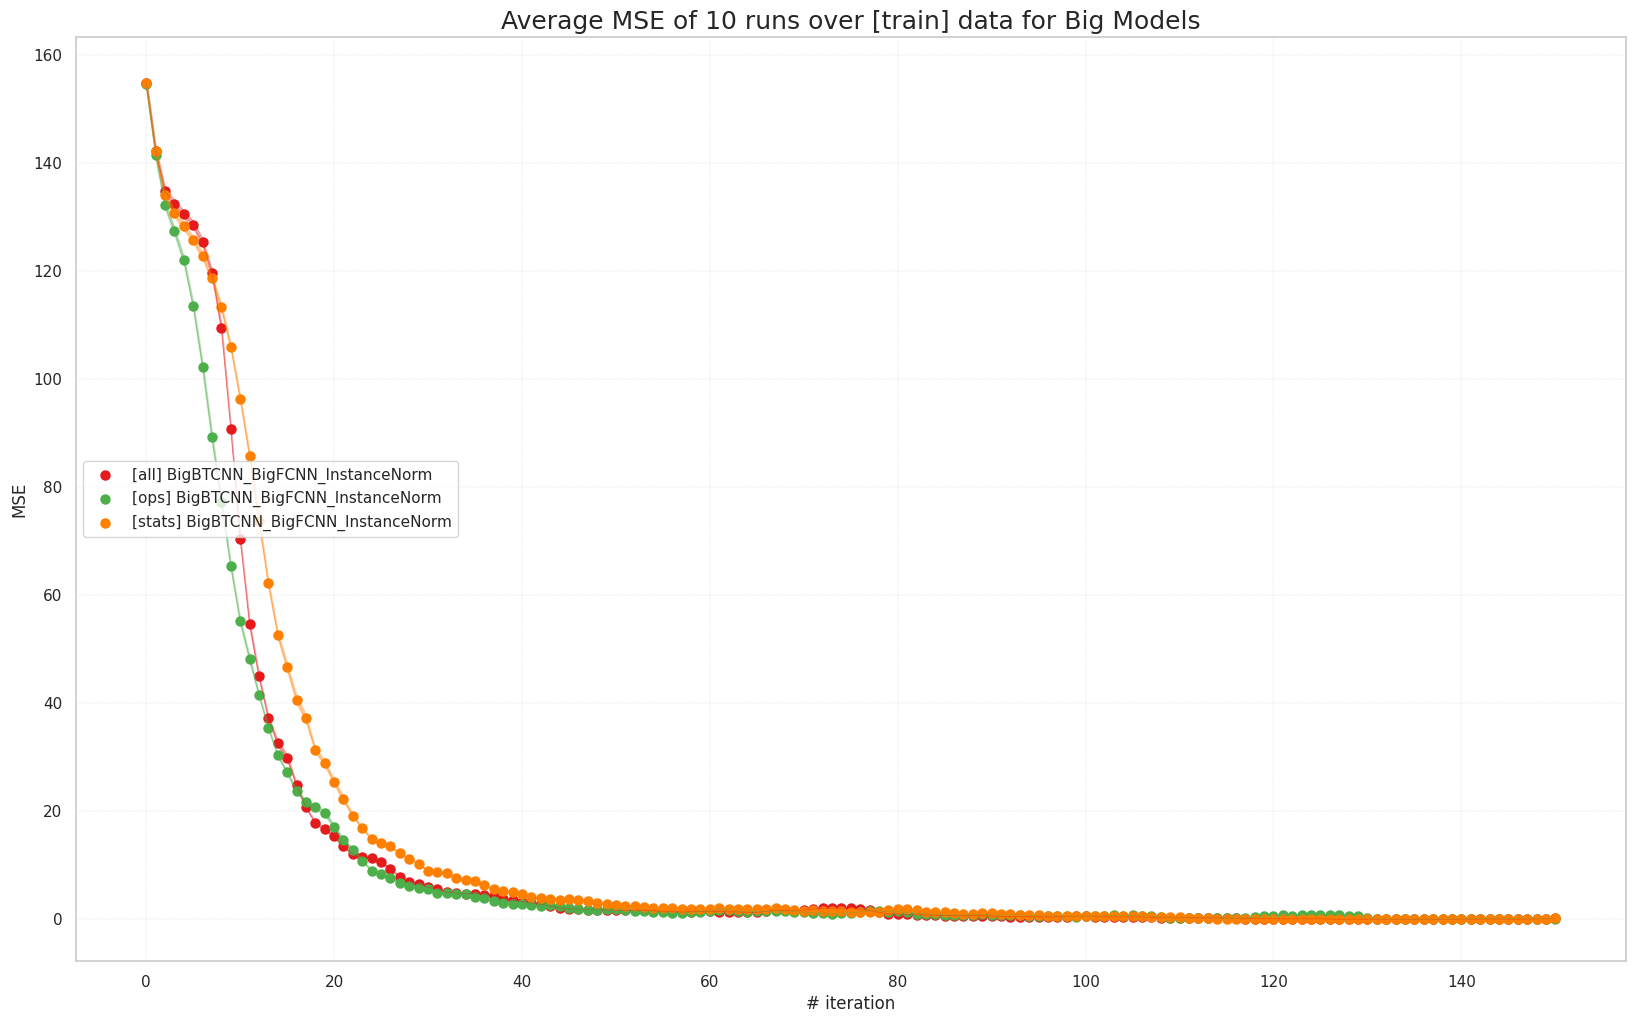

As can be seen, the learning dynamics on such data is better - already by epoch 50 the error on the data reaches less than 1. That is, despite the fact that there are common patterns in the original data, which in theory can make the learning task easier, the NN copes faster with the help of blunt memorisation of examples if their feature description has a simple structure (no sharp elevations, collisions and so on).

### Statement #4: the dynamics of learning at points with small predictions is difficult by itself

To make the predictions positive and at the same time be able to get *feedback* from small predictions during back propagation, we decided to add activation at the end of the NN and chose the `softplus` layer instead of `relu`. But this has consequences - the derivative of the `softplus` layer for small predictions is very small, so the learning speed in these areas may lead to overestimates.

In [363]:
train_df.loc[
    ((train_df["prediction_category"] == "overestimated") & (train_df["is_dirty"] == False)),
    ["mape", "time", "prediction", "frequency", "time_category", "prediction_category", "embedding", "is_dirty", "abs_error"]
].sort_values(by=["mape"], ascending=False)[:10]

,mape,time,prediction,frequency,time_category,prediction_category,embedding,is_dirty,abs_error
3417,1710.742480,0.000611,1.045264,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,1.044653
1819,1039.990263,0.000882,0.917271,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.916389
655,978.014939,0.000752,0.735467,4,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.19...",False,0.734715
5205,967.154942,0.000446,0.431351,4,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.02...",False,0.430905
595,956.817030,0.000796,0.761626,2,small,overestimated,"[tensor(-0.0055), tensor(0.3961), tensor(0.172...",False,0.760830
4778,807.351463,0.000237,0.191073,30,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.190837
3879,798.393288,0.001062,0.847894,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.846832
4547,771.558846,0.000412,0.317882,4,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.317470
889,745.973875,0.000587,0.437887,2,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(1.31...",False,0.437300
1858,745.493047,0.000721,0.537501,1,small,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.536780


In [364]:
FREQUENT_AND_OVERESTIMATED_IDX = 4778
target_v, target_e, target_embedding, target_y = train_df.loc[FREQUENT_AND_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")

100%|██████████| 23/23 [00:01<00:00, 22.15it/s]

distance 0.000 | real time 0.000 | prediction 0.191 | is_dirty=False
distance 0.101 | real time 0.000 | prediction 0.150 | is_dirty=False
distance 0.218 | real time 0.754 | prediction 0.873 | is_dirty=True
distance 0.233 | real time 0.001 | prediction 0.145 | is_dirty=False
distance 0.243 | real time 0.754 | prediction 0.745 | is_dirty=True
distance 0.255 | real time 0.754 | prediction 0.824 | is_dirty=True
distance 0.255 | real time 0.001 | prediction 0.213 | is_dirty=False
distance 0.257 | real time 0.001 | prediction 0.112 | is_dirty=False
distance 0.262 | real time 0.001 | prediction 0.112 | is_dirty=False
distance 0.263 | real time 0.001 | prediction 0.095 | is_dirty=False


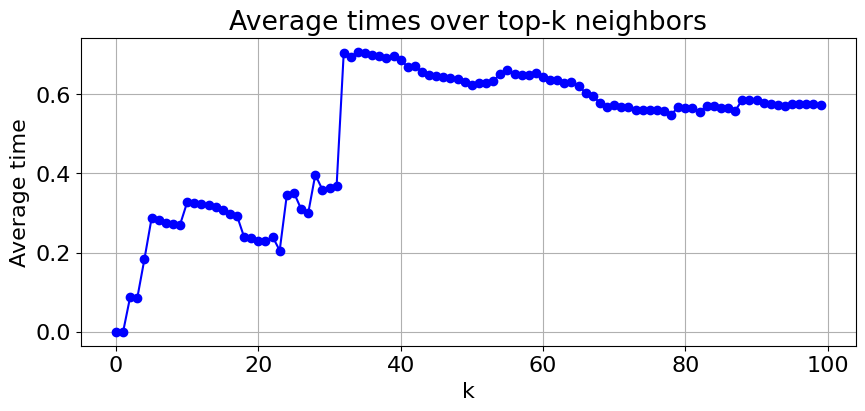

In [365]:
plot_avg_knn_times(support_points)

In [366]:
FREQUENT_AND_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    FREQUENT_AND_OVERESTIMATED_IDX, train_df, 20, 100, noise_level=.1
)

100%|██████████| 23/23 [00:00<00:00, 23.01it/s]


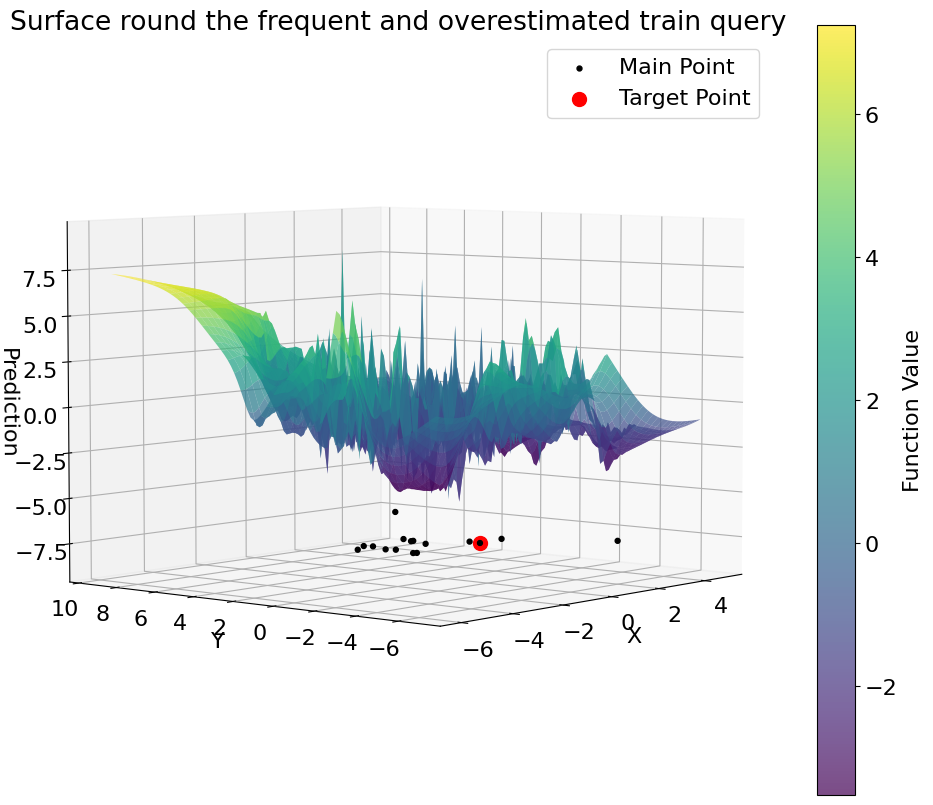

In [367]:
plot_3d_surface(
    *FREQUENT_AND_OVERESTIMATED_ARGS, 
    "Surface round the frequent and overestimated train query",  None, 5, 220, softplus_rescale=True, with_auxilary_points=False, projector=PCA
)

Note - we visualized the dependency **before** including the final `softplus` layer (which we’ll call $\hat{y}$). This visualization revealed difficulties in predicting lower values **across most scenarios**, likely due to this layer. Specifically, the derivative of the `softplus` is $\frac{1}{1+e^{-\hat{y}}}$, and when predicting $y \approx 0.2$, $\hat{y}$ values are close to 2.5. So, in that regions the gradient is reduced in **10** times. Consequently, with a small `lr` in the later stages of training, it becomes challenging to adjust weights effectively in such demanding areas.

## Validation data

**Observation:** 

$metric|_{train} \ll metric|_{val}$ for **ANY** metric on **ANY** subset

Is seems that there's no possiblity for complete generalization. Cause of that complex dependency between plans and times it may be impossible to correctly interpolate knowledge.

In [513]:
filter_metrics_df(aggregated_metrics_df, ["train"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
0,train,all,all,all,all,34914,0.059±0.007,12.508±2.046
1,train,all,all,all,underestimated,13546,0.071±0.011,0.196±0.042
2,train,all,all,all,overestimated,21369,0.054±0.010,20.887±4.618
3,train,all,all,small,all,8627,0.035±0.017,50.414±8.734
4,train,all,all,small,underestimated,2381,0.004±0.000,0.428±0.034
5,train,all,all,small,overestimated,6246,0.048±0.024,69.494±11.574
6,train,all,all,medium,all,17412,0.034±0.005,0.144±0.015
7,train,all,all,medium,underestimated,7786,0.043±0.013,0.197±0.041
8,train,all,all,medium,overestimated,9626,0.030±0.005,0.111±0.006
9,train,all,all,big,all,8875,0.132±0.011,0.014±0.001


In [514]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
108,val,all,all,all,all,8478,33.457±8.367,43.165±6.769
109,val,all,all,all,underestimated,4020,53.229±16.023,0.324±0.024
110,val,all,all,all,overestimated,4457,16.218±4.077,82.249±14.522
111,val,all,all,small,all,1931,6.721±5.113,188.560±34.780
112,val,all,all,small,underestimated,552,0.004±0.000,0.466±0.043
113,val,all,all,small,overestimated,1379,9.184±6.707,261.521±36.345
114,val,all,all,medium,all,4260,5.378±1.910,0.967±0.177
115,val,all,all,medium,underestimated,2105,0.538±0.136,0.324±0.022
116,val,all,all,medium,overestimated,2155,10.113±3.667,1.613±0.400
117,val,all,all,big,all,2287,109.578±30.465,0.245±0.007


### Statement #5: the sharpness of the landscape is one of the challenges in generalisation

Probably most often errors are reached in the "peaks" before mountains with the transition of fast queries to long queries. 

In [368]:
val_df = load_run_and_get_filtered_df(1, "val", "all", "all", "all", "all")

In [372]:
val_df["abs_error"] = val_df["error"].abs()
val_df["mape"] = val_df["prediction"] / val_df["time"] .abs()
val_df["is_dirty"] = val_df.apply(lambda row: is_dirty(*preprocess(row["vertices"], row["edges"])), axis=1)

#### most overestimated

In [373]:
val_df.loc[
    (val_df["is_dirty"] == False) & (val_df["prediction_category"] == "overestimated"),
    ["abs_error", "time", "prediction", "frequency", "time_category", "prediction_category", "embedding", "is_dirty", "mape"]
].sort_values(by="abs_error", ascending=False).head()

,abs_error,time,prediction,frequency,time_category,prediction_category,embedding,is_dirty,mape
6182,15.472553,2.992474,18.465027,16,medium,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,6.170489
6322,10.885094,0.642389,11.527483,8,medium,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,17.944721
6501,9.677376,2.615051,12.292427,4,medium,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.12...",False,4.700645
6056,8.125973,53.265110,61.391083,8,big,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.34...",False,1.152557
6839,7.452736,19.741898,27.194633,6,big,overestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,1.377509


In [376]:
MOST_OVERESTIMATED_IDX = 6182
target_v, target_e, target_embedding, target_y = val_df.loc[MOST_OVERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")

100%|██████████| 23/23 [00:00<00:00, 26.98it/s]

distance 0.272 | real time 22.663 | prediction 22.857 | is_dirty=True
distance 0.304 | real time 5.478 | prediction 5.542 | is_dirty=True
distance 0.310 | real time 5.041 | prediction 5.067 | is_dirty=True
distance 0.346 | real time 32.400 | prediction 32.528 | is_dirty=True
distance 0.412 | real time 7.234 | prediction 7.390 | is_dirty=True
distance 0.436 | real time 11.355 | prediction 11.512 | is_dirty=False
distance 0.462 | real time 8.506 | prediction 8.662 | is_dirty=True
distance 0.469 | real time 2.086 | prediction 2.110 | is_dirty=True
distance 0.488 | real time 10.486 | prediction 10.603 | is_dirty=False
distance 0.509 | real time 3.749 | prediction 3.756 | is_dirty=True


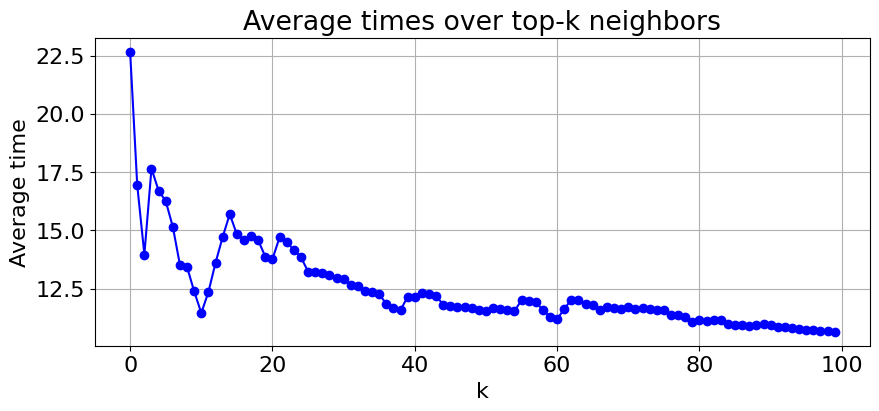

In [377]:
plot_avg_knn_times(support_points)

In [379]:
MOST_OVERESTIMATED_ARGS = prepare_args_for_3d_plot(
    MOST_OVERESTIMATED_IDX, val_df, 20, 100, noise_level=.1
)

100%|██████████| 23/23 [00:01<00:00, 22.63it/s]


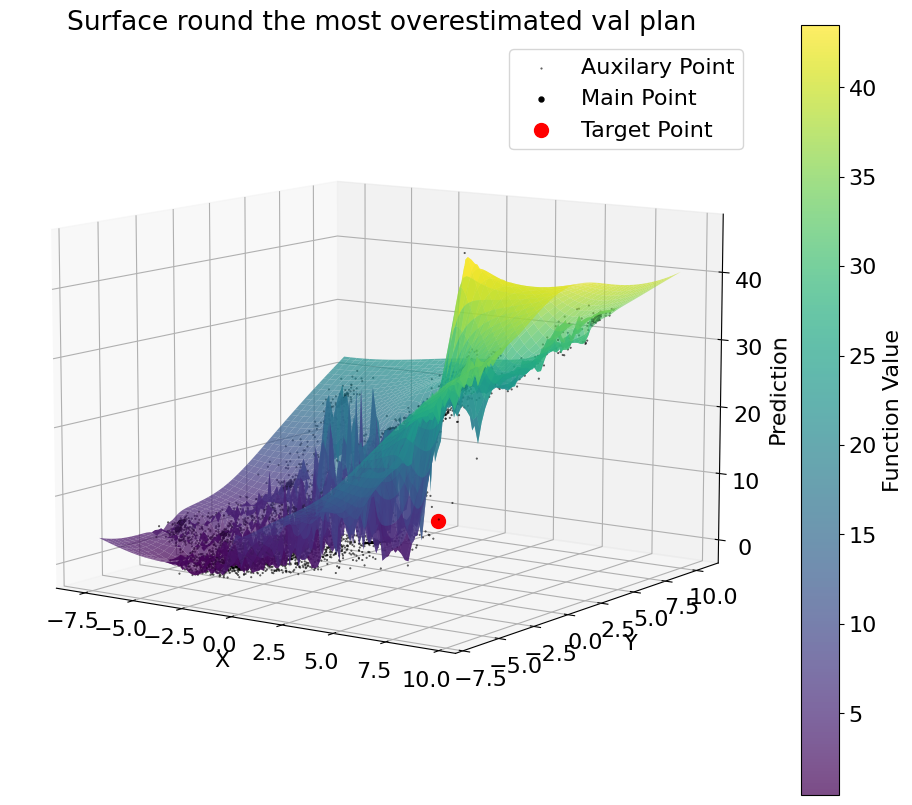

In [400]:
plot_3d_surface(
    *MOST_OVERESTIMATED_ARGS, 
    "Surface round the most overestimated val plan",  None, 10, -55, softplus_rescale=False, with_auxilary_points=True, projector=PCA
)

We see, that many close plans are big and `TIMEOUT`ed, and learned landscape isn't sharp enough to predict so small value (3sec) on the slope. 
In fact, the neural network had no information that this peak was so sharp, so its behaviour is completely justified by the train data.

#### most underestimated

In [401]:
val_df.loc[
    (val_df["is_dirty"] == False) & (val_df["prediction_category"] == "underestimated"),
    ["abs_error", "time", "prediction", "frequency", "time_category", "prediction_category", "embedding", "is_dirty", "mape"]
].sort_values(by="abs_error", ascending=False).head()

,abs_error,time,prediction,frequency,time_category,prediction_category,embedding,is_dirty,mape
6291,51.529469,99.418854,47.889385,4,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(0.06...",False,0.481693
6905,32.316861,32.359970,0.043109,2,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.001332
7160,32.127382,32.136410,0.009028,2,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.000281
7182,32.090342,32.397373,0.307031,4,big,underestimated,"[tensor(-0.0055), tensor(0.1355), tensor(-0.03...",False,0.009477
5944,30.541203,31.674522,1.133319,2,big,underestimated,"[tensor(-0.0055), tensor(-0.0206), tensor(-0.0...",False,0.035780


In [410]:
MOST_UNDERESTIMATED_IDX = 6291
target_v, target_e, target_embedding, target_y = val_df.loc[MOST_UNDERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")

100%|██████████| 23/23 [00:00<00:00, 26.38it/s]

distance 0.373 | real time 53.171 | prediction 53.191 | is_dirty=False
distance 0.376 | real time 73.216 | prediction 73.452 | is_dirty=False
distance 0.378 | real time 72.767 | prediction 73.148 | is_dirty=False
distance 0.379 | real time 72.891 | prediction 73.171 | is_dirty=False
distance 0.380 | real time 72.992 | prediction 73.495 | is_dirty=False
distance 0.383 | real time 70.447 | prediction 70.441 | is_dirty=False
distance 0.384 | real time 69.923 | prediction 70.173 | is_dirty=False
distance 0.385 | real time 72.969 | prediction 73.256 | is_dirty=False
distance 0.385 | real time 73.116 | prediction 73.346 | is_dirty=False
distance 0.386 | real time 69.747 | prediction 70.150 | is_dirty=False


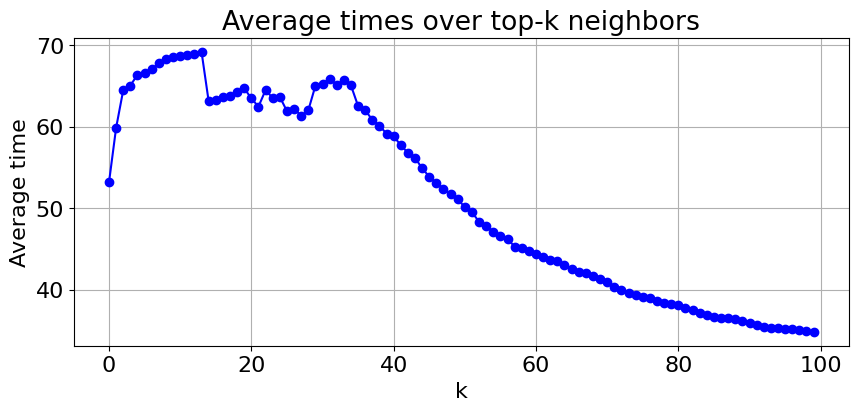

In [411]:
plot_avg_knn_times(support_points)

In [412]:
MOST_UNDERESTIMATED_ARGS = prepare_args_for_3d_plot(
    MOST_UNDERESTIMATED_IDX, val_df, 20, 100, noise_level=.1
)

100%|██████████| 23/23 [00:01<00:00, 20.96it/s]


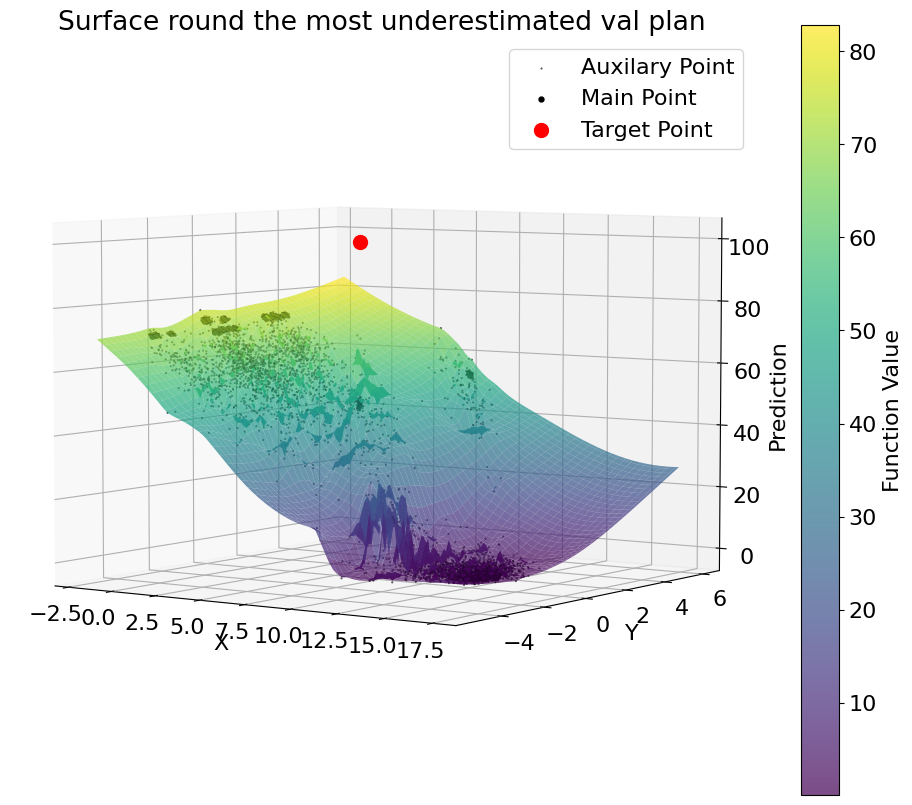

In [414]:
plot_3d_surface(
    *MOST_UNDERESTIMATED_ARGS, 
    "Surface round the most underestimated val plan",  None, 5, -55, softplus_rescale=False, with_auxilary_points=True, projector=PCA
)

We see, there're just no points with such big execution time in train data, so NN virtually hadn't opportunity to predict that.

#### dependency on split

Another way to proof that statement is to check the reason of instability of MSE on val data on different splits.

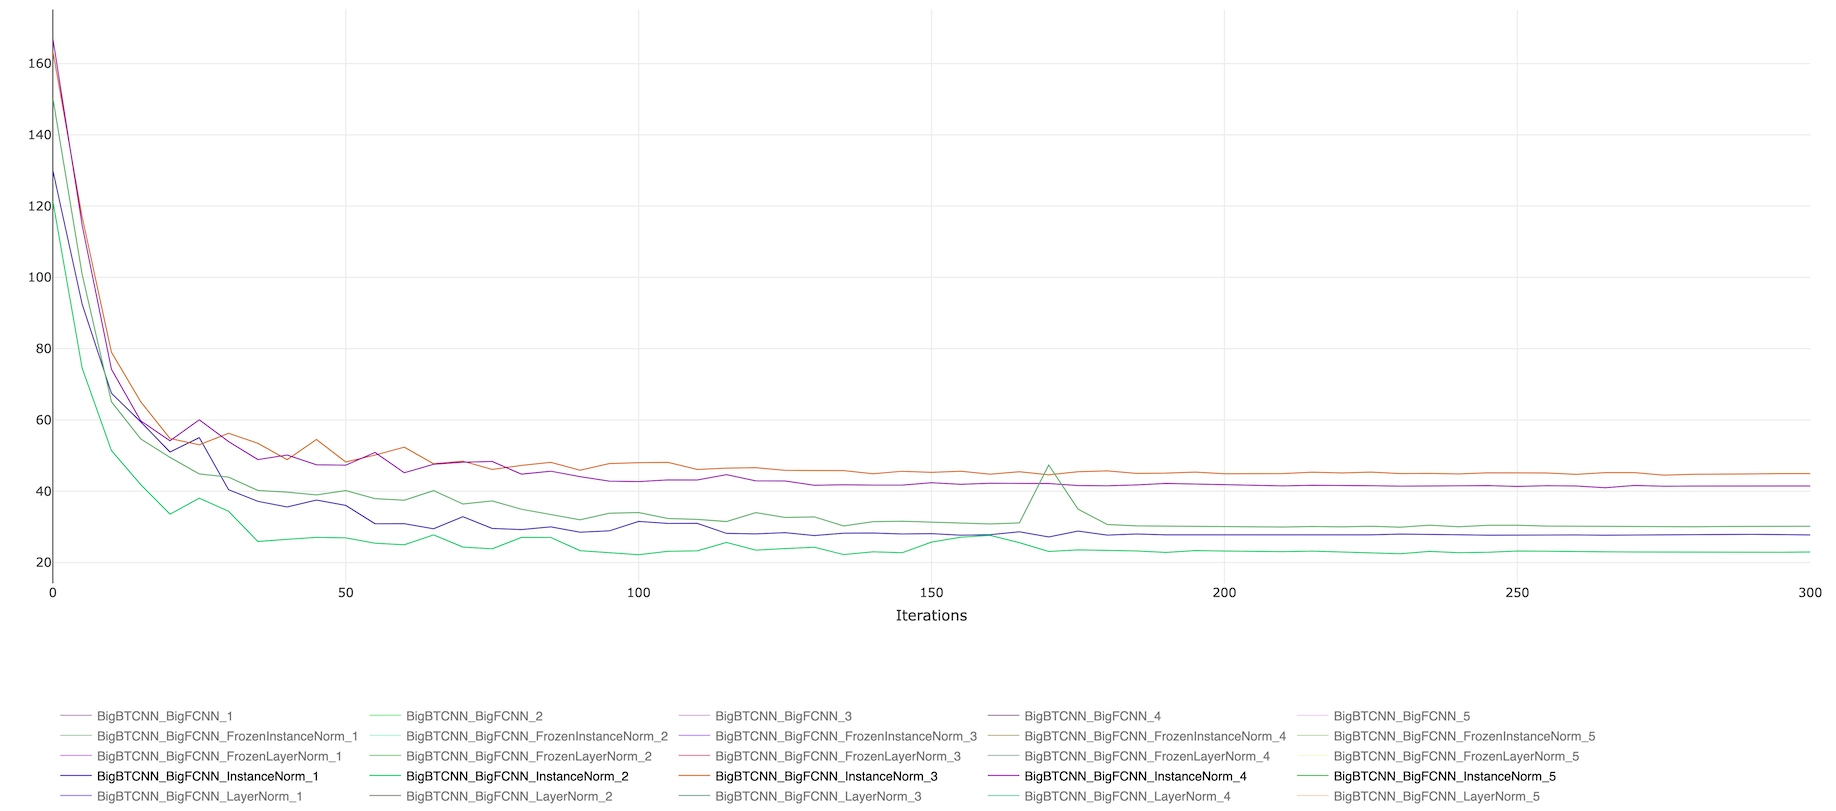

In [433]:
best_run_val_df = load_run_and_get_filtered_df(2, "val", "all", "all", "all", "all")
worst_run_val_df = load_run_and_get_filtered_df(3, "val", "all", "all", "all", "all")

In [434]:
best_run_val_df["abs_error"] = best_run_val_df["error"].abs()
best_run_val_df["mape"] = best_run_val_df["prediction"] / best_run_val_df["time"] .abs()
best_run_val_df["is_dirty"] = best_run_val_df.apply(lambda row: is_dirty(*preprocess(row["vertices"],  row["edges"])), axis=1)

In [457]:
best_run_val_df.loc[
    :,
    ["mape", "time", "prediction", "frequency", "tree_category", "prediction_category", "embedding", "is_dirty", "abs_error"]
].sort_values(by=["abs_error"], ascending=False).head()

,mape,time,prediction,frequency,tree_category,prediction_category,embedding,is_dirty,abs_error
6485,0.007281,64.272820,0.467968,4,unseen,underestimated,"[tensor(-0.0099), tensor(0.0012), tensor(0.334...",True,63.804851
6644,0.008286,62.164761,0.515116,4,unseen,underestimated,"[tensor(-0.0099), tensor(0.0012), tensor(0.089...",True,61.649645
7243,0.027885,62.164761,1.733446,2,unseen,underestimated,"[tensor(-0.0099), tensor(0.0012), tensor(0.225...",True,60.431315
6345,0.066774,64.719940,4.321623,4,unseen,underestimated,"[tensor(-0.0099), tensor(0.0012), tensor(0.188...",True,60.398317
6900,6.124023,10.764966,65.924896,2,unseen,overestimated,"[tensor(-0.0099), tensor(0.0012), tensor(0.912...",True,55.159930


In [436]:
worst_run_val_df["abs_error"] = worst_run_val_df["error"].abs()
worst_run_val_df["mape"] = worst_run_val_df["prediction"] / worst_run_val_df["time"] .abs()
worst_run_val_df["is_dirty"] = worst_run_val_df.apply(lambda row: is_dirty(*preprocess(row["vertices"],  row["edges"])), axis=1)

In [456]:
worst_run_val_df.loc[
    :,
    ["mape", "time", "prediction", "frequency", "tree_category", "prediction_category", "embedding", "is_dirty", "abs_error"]
].sort_values(by=["abs_error"], ascending=False).head()

,mape,time,prediction,frequency,tree_category,prediction_category,embedding,is_dirty,abs_error
6103,0.093371,139.207626,12.998000,4,unseen,underestimated,"[tensor(1.0500), tensor(0.0171), tensor(0.1408...",True,126.209626
5955,3.228108,43.000061,138.808823,4,unseen,overestimated,"[tensor(1.1093), tensor(1.6063), tensor(1.5425...",True,95.808762
7250,0.269384,101.969879,27.469103,16,unseen,underestimated,"[tensor(-0.0079), tensor(0.0987), tensor(0.059...",False,74.500776
7124,0.074795,66.403702,4.966694,2,unseen,underestimated,"[tensor(0.9817), tensor(0.5260), tensor(0.8524...",True,61.437008
6473,0.414699,99.418854,41.228897,4,unseen,underestimated,"[tensor(-0.0079), tensor(0.5783), tensor(0.051...",False,58.189957


In [478]:
worst_mean_mse = 45
worst_total_count = worst_run_val_df["frequency"].sum()
worst_total_mse = worst_total_count * worst_mean_mse

top_3_mse = (4 * (126 ** 2) + 4 * (96 ** 2) + 16 * (74 ** 2))
print(f"The propotion of MSE from worst 3 plans on the worst run is {100 * top_3_mse / worst_total_mse:0.1f}%")

The propotion of MSE from worst 3 plans on the worst run is 50.2%


In [486]:
WORST_IDX = 6103
target_v, target_e, target_embedding, target_y = worst_run_val_df.loc[WORST_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:15<00:00,  1.52it/s]

distance 1.013 | real time 0.034 | prediction 0.147 | is_dirty=False
distance 1.017 | real time 0.178 | prediction 0.180 | is_dirty=False
distance 1.031 | real time 0.001 | prediction 0.109 | is_dirty=False
distance 1.040 | real time 0.056 | prediction 0.075 | is_dirty=False
distance 1.050 | real time 0.001 | prediction 0.438 | is_dirty=False
distance 1.054 | real time 0.103 | prediction 0.053 | is_dirty=False
distance 1.055 | real time 0.001 | prediction 0.330 | is_dirty=False
distance 1.056 | real time 0.405 | prediction 0.381 | is_dirty=False
distance 1.057 | real time 1.325 | prediction 0.490 | is_dirty=False
distance 1.058 | real time 0.009 | prediction 0.095 | is_dirty=False


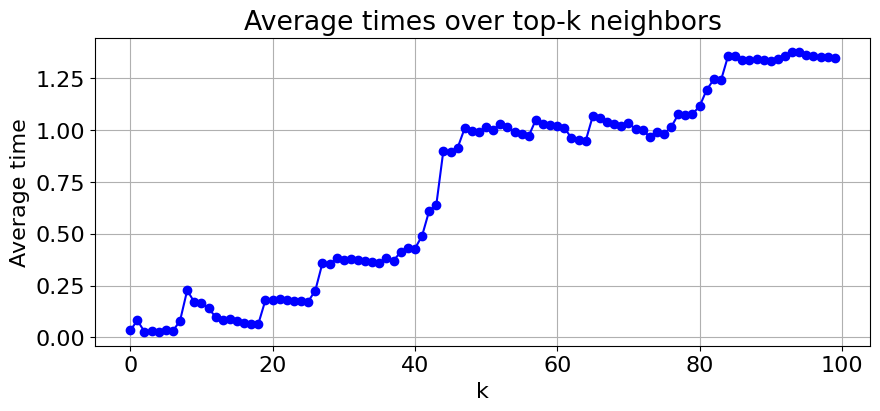

In [487]:
plot_avg_knn_times(support_points)

In [488]:
print("Queries and parameters that lead to target plan (query, hs, dop):")
[(q_n, hs, dop) for q_n, hs, dop, t in get_query_info(*preprocess(target_v, target_e), TRAIN_VE_TO_TIMES, TRAIN_VET_TO_QUERY_INFO, job_oracle)]

Queries and parameters that lead to target plan (query, hs, dop):


[('16b', 14, 64), ('16b', 42, 64), ('16b', 10, 64), ('16b', 46, 64)]

In [493]:
print(f"Execution time of default plan is ~{job_oracle.get_execution_time(OracleRequest(query_name='16b', hintset=0, dop=64)) / 1000:0.3f} sec, that is the longest query in JOB")

Execution time of default plan is ~69.604 sec, that is the longest query in JOB


In [492]:
print("Queries and parameters from closest plan (qery, hs, dop, time):")
d, closest_v, closest_e, *_ = sorted(support_points, key=lambda x: x[0])[0]
[(q_n, hs, dop, t/1000) for q_n, hs, dop, t in get_query_info(closest_v, closest_e, TRAIN_VE_TO_TIMES, TRAIN_VET_TO_QUERY_INFO, job_oracle)]

Queries and parameters from closest plan (qery, hs, dop, time):


[('33a', 83, 16, 0.034684),
 ('33a', 87, 16, 0.034684),
 ('33a', 87, 64, 0.033645),
 ('33a', 83, 64, 0.033645),
 ('33a', 83, 16, 0.034684),
 ('33a', 87, 16, 0.034684),
 ('33a', 87, 64, 0.033645),
 ('33a', 83, 64, 0.033645)]

As we can see, the longest query `16b` isn't presented in train data. The closest train data to it are plans for super-fast query `33a`, which led to huge underestimation.

Just 3 such situations with huge underestimations are already enough to increase MSE by 2 times!

### Statement #6: tree structure helps in generalization

We can see that $metric|_{seen\_structure} \ll metric|_{unseen\_structure}$ for **ANY** metric on **ANY** subset, i.e. tree stucture helps NN in generalization.

In [421]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["seen"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
144,val,seen,all,all,all,5124,8.759±0.000,22.101±0.000
145,val,seen,all,all,underestimated,2611,13.479±0.000,0.242±0.000
146,val,seen,all,all,overestimated,2513,3.855±0.000,44.813±0.000
147,val,seen,all,small,all,1160,0.806±0.000,96.474±0.000
148,val,seen,all,small,underestimated,266,0.005±0.000,0.413±0.000
149,val,seen,all,small,overestimated,894,1.045±0.000,125.056±0.000
150,val,seen,all,medium,all,2411,1.859±0.000,0.456±0.000
151,val,seen,all,medium,underestimated,1377,0.238±0.000,0.260±0.000
152,val,seen,all,medium,overestimated,1034,4.017±0.000,0.718±0.000
153,val,seen,all,big,all,1553,25.411±0.000,0.152±0.000


In [422]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["unseen"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
180,val,unseen,all,all,all,2837,48.612±0.000,109.797±0.000
181,val,unseen,all,all,underestimated,1386,68.255±0.000,0.373±0.000
182,val,unseen,all,all,overestimated,1451,29.850±0.000,214.318±0.000
183,val,unseen,all,small,all,673,5.823±0.000,458.082±0.000
184,val,unseen,all,small,underestimated,126,0.003±0.000,0.361±0.000
185,val,unseen,all,small,overestimated,547,7.164±0.000,563.517±0.000
186,val,unseen,all,medium,all,1425,8.876±0.000,2.043±0.000
187,val,unseen,all,medium,underestimated,777,0.768±0.000,0.377±0.000
188,val,unseen,all,medium,overestimated,648,18.597±0.000,4.040±0.000
189,val,unseen,all,big,all,739,164.204±0.000,0.396±0.000


### Statement #7: statistics are more descriptive feature in generalization than tree structures

We can demonstrate this by comparing the losses on validation data with noise replacing the tree structure and noise substituting for the statistics.

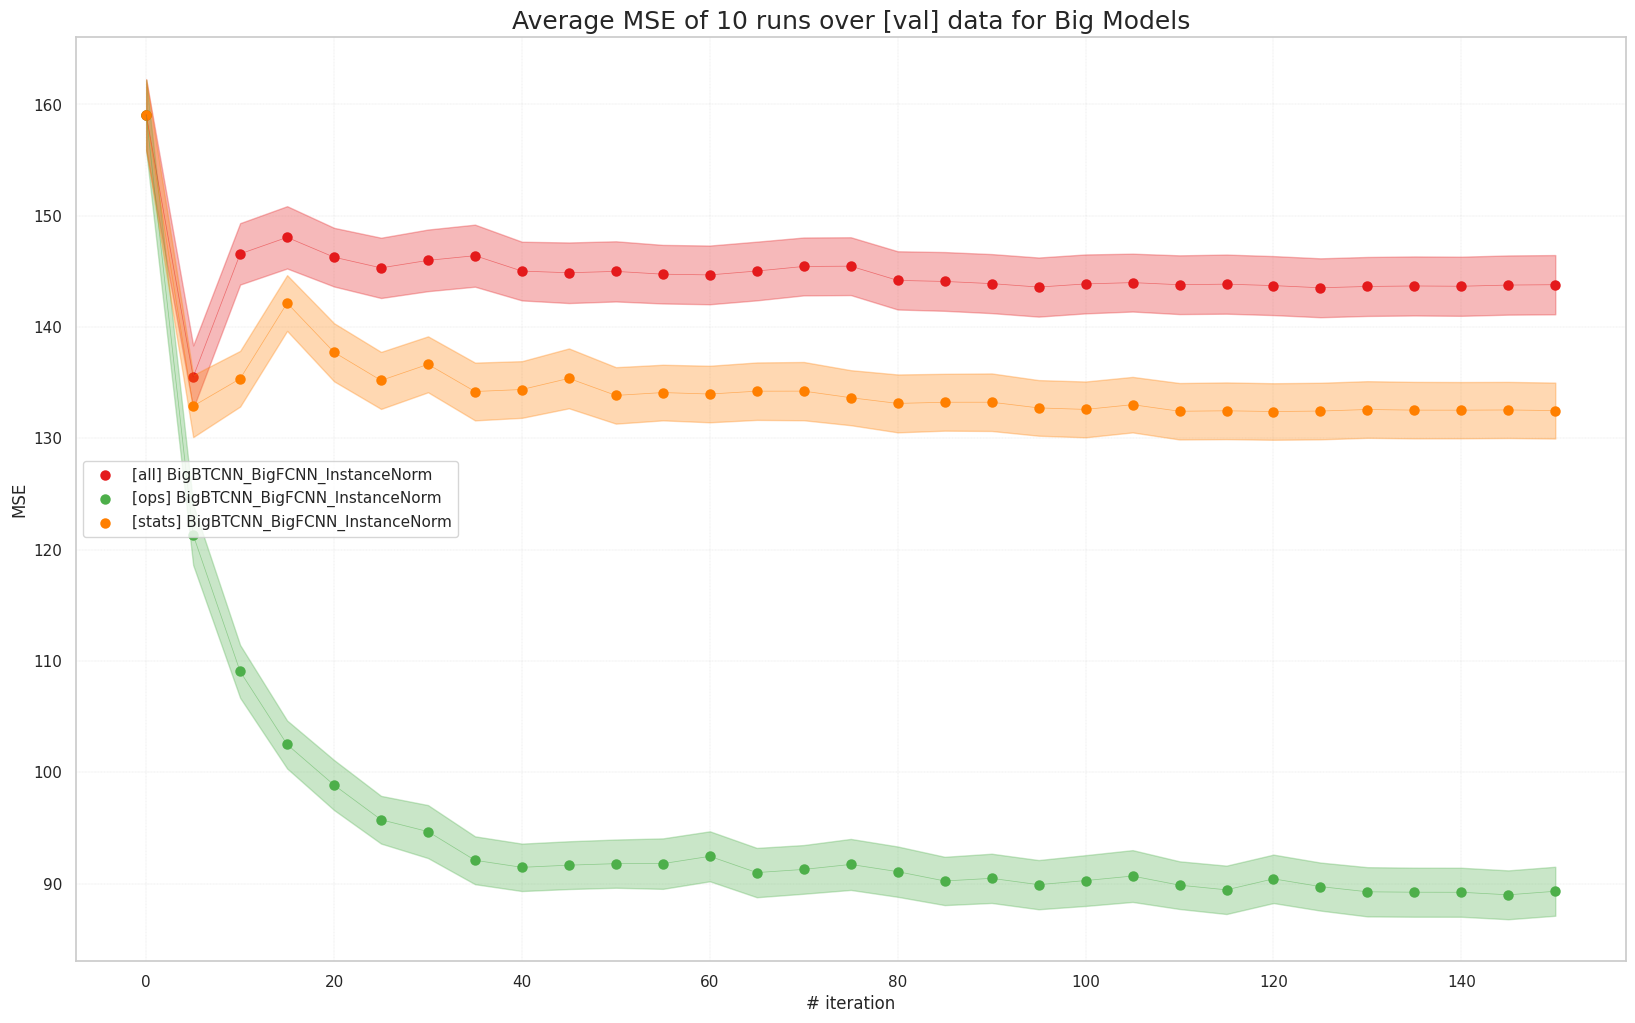

This is not surprising, as statistics already include data size information, which is crucial for time prediction. Essentially, the neural network should act as a global cost model in this scenario. When information about the tree structure is available, it can transform into a contextual cost model, adjusting global cost parameters based on the specific case.

At this stage, a key question may appear:
<center><i>"Whether generalisation is really taking place, or whether the model is just mimicking the cost model (and possibly performing even worse than the standard one)?".</i></center>

 In order to answer this question, a separate experiment will be set up in the future.

## Test data

**Observation:** 

$metric|_{val} \ll metric|_{train}$ for almost **ANY** metric on **ANY** subset

Probably, on average, the data in the `test` is similar to a huge number of queries from the `train`, and with any split, most of it is well represented.

In [515]:
filter_metrics_df(aggregated_metrics_df, ["test"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
216,test,all,all,all,all,4992,26.463±15.334,11.700±2.607
217,test,all,all,all,underestimated,1950,53.624±36.072,0.137±0.015
218,test,all,all,all,overestimated,3042,8.969±5.406,19.276±4.929
219,test,all,all,small,all,1766,3.187±2.267,32.810±7.315
220,test,all,all,small,underestimated,172,0.001±0.000,0.355±0.120
221,test,all,all,small,overestimated,1594,3.521±2.504,36.342±7.934
222,test,all,all,medium,all,1238,0.750±0.961,0.287±0.079
223,test,all,all,medium,underestimated,671,0.169±0.111,0.193±0.037
224,test,all,all,medium,overestimated,567,1.723±2.702,0.423±0.184
225,test,all,all,big,all,1988,63.152±37.264,0.054±0.002


In [516]:
filter_metrics_df(aggregated_metrics_df, ["val"], ["all"], ["all"], None, None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
108,val,all,all,all,all,8478,33.457±8.367,43.165±6.769
109,val,all,all,all,underestimated,4020,53.229±16.023,0.324±0.024
110,val,all,all,all,overestimated,4457,16.218±4.077,82.249±14.522
111,val,all,all,small,all,1931,6.721±5.113,188.560±34.780
112,val,all,all,small,underestimated,552,0.004±0.000,0.466±0.043
113,val,all,all,small,overestimated,1379,9.184±6.707,261.521±36.345
114,val,all,all,medium,all,4260,5.378±1.910,0.967±0.177
115,val,all,all,medium,underestimated,2105,0.538±0.136,0.324±0.022
116,val,all,all,medium,overestimated,2155,10.113±3.667,1.613±0.400
117,val,all,all,big,all,2287,109.578±30.465,0.245±0.007


### Statement #8: substructures are also important for generalisation

In [519]:
aggregated_neighborhoods_df[aggregated_neighborhoods_df["data_type"] == "train"]

,height,data_type,match_probability
0,1,train,0.853±0.005
2,2,train,0.723±0.006
4,3,train,0.621±0.006
6,4,train,0.527±0.005


In [520]:
aggregated_neighborhoods_df[aggregated_neighborhoods_df["data_type"] == "test"]

,height,data_type,match_probability
1,1,test,0.975±0.006
3,2,test,0.952±0.009
5,3,test,0.933±0.011
7,4,test,0.914±0.013


We see that, on average, the probability of encountering subtrees of height 1-4 in the `test` is significantly higher. This must have a positive effect on the borrowing of knowledge from the `train` and allows for better prediction on the `test`. 

Note that there is no point in considering trees of greater height - as we only use 4 tree convolutional layers.

## OOD Data

**Observation:**

$mse|_{underestimated} \ll mse|_{overestimated}$

The main problem with `ood` data is huge underestimation of super-long queries.

In [522]:
filter_metrics_df(aggregated_metrics_df, ["ood"], ["all"], ["all"], ["big"], None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
333,ood,all,all,big,all,1984,2045.611±7.745,0.940±0.004
334,ood,all,all,big,underestimated,1959,2070.857±10.200,0.945±0.004
335,ood,all,all,big,overestimated,25,110.802±50.922,0.548±0.091


In [523]:
filter_metrics_df(aggregated_metrics_df, ["ood"], ["all"], ["all"], ["medium"], None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
330,ood,all,all,medium,all,1455,8.741±2.394,2.095±0.395
331,ood,all,all,medium,underestimated,806,1.766±0.206,0.632±0.056
332,ood,all,all,medium,overestimated,649,17.528±4.981,3.881±0.682


In [524]:
filter_metrics_df(aggregated_metrics_df, ["ood"], ["all"], ["all"], ["small"], None)

,data_type,structure_category,tree_category,time_category,prediction_category,size,mse,mape
327,ood,all,all,small,all,1553,8.968±1.982,326.232±76.940
328,ood,all,all,small,underestimated,223,0.003±0.000,0.632±0.160
329,ood,all,all,small,overestimated,1330,10.559±2.631,379.330±82.390


In [526]:
ood_df = load_run_and_get_filtered_df(1, "ood", "all", "all", "all", "all")

In [528]:
ood_df["abs_error"] = ood_df["error"].abs()
ood_df["mape"] = ood_df["prediction"] / ood_df["time"] .abs()

In [534]:
ood_df.loc[
    :,
    ["abs_error", "time", "prediction", "frequency", "time_category", "prediction_category", "mape"]
].sort_values(by="abs_error", ascending=False).head()

,abs_error,time,prediction,frequency,time_category,prediction_category,mape
9614,139.391307,139.689804,0.298497,2,big,underestimated,0.002137
9606,138.568786,139.689804,1.121018,4,big,underestimated,0.008025
9611,138.211611,139.689804,1.478194,3,big,underestimated,0.010582
9610,137.953108,139.689804,1.736696,3,big,underestimated,0.012433
9605,137.874820,139.477707,1.602887,4,big,underestimated,0.011492


In [539]:
MOST_UNDERESTIMATED_IDX = 9614
target_v, target_e, target_embedding, target_y = ood_df.loc[MOST_UNDERESTIMATED_IDX][["vertices", "edges", "embedding", "time"]]
support_points, all_distances = get_k_support_points_and_all_distances(target_embedding, train_dataloader, k=100)

for d, v, e, f, t, p, emb in sorted(support_points, key=lambda x: x[0])[:10]:
    print(f"distance {d:0.3f} | real time {t:0.3f} | prediction {p:0.3f} | is_dirty={is_dirty(v, e)}")

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 25.04it/s]


distance 0.396 | real time 1.559 | prediction 1.593 | is_dirty=False
distance 0.418 | real time 0.816 | prediction 0.967 | is_dirty=True
distance 0.422 | real time 0.787 | prediction 0.667 | is_dirty=True
distance 0.427 | real time 0.305 | prediction 0.320 | is_dirty=True
distance 0.427 | real time 0.386 | prediction 0.321 | is_dirty=True
distance 0.437 | real time 1.278 | prediction 1.428 | is_dirty=False
distance 0.439 | real time 1.003 | prediction 0.455 | is_dirty=False
distance 0.441 | real time 0.174 | prediction 0.277 | is_dirty=True
distance 0.448 | real time 0.001 | prediction 0.083 | is_dirty=True
distance 0.450 | real time 2.445 | prediction 2.561 | is_dirty=True


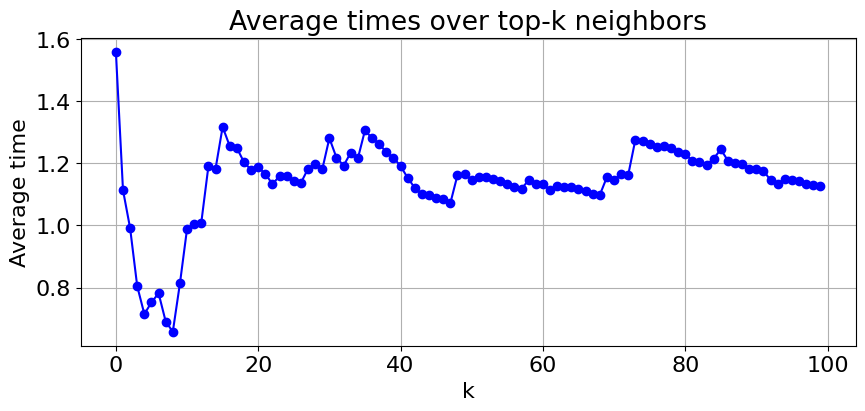

In [540]:
plot_avg_knn_times(support_points)

In [545]:
print("Queries and parameters that lead to target plan (query, hs, dop, time):")
[(q_n, hs, dop, t/1000) for q_n, hs, dop, t in get_query_info(*preprocess(target_v, target_e), OOD_VE_TO_TIMES, OOD_VET_TO_QUERY_INFO, sq_oracle)]

Queries and parameters that lead to target plan (query, hs, dop, time):


[('q10_2a265', 26, 16, 4398046511.104), ('q10_2a265', 30, 16, 4398046511.104)]

In [544]:
print("Queries and parameters from closest plan (qery, hs, dop, time):")
d, closest_v, closest_e, *_ = sorted(support_points, key=lambda x: x[0])[1]
[(q_n, hs, dop, t/1000) for q_n, hs, dop, t in get_query_info(closest_v, closest_e, TRAIN_VE_TO_TIMES, TRAIN_VET_TO_QUERY_INFO, job_oracle)]

Queries and parameters from closest plan (qery, hs, dop, time):


[('22c', 126, 16, 4398046511.104),
 ('22c', 122, 16, 4398046511.104),
 ('22c', 58, 16, 4398046511.104),
 ('22c', 62, 16, 4398046511.104),
 ('22c', 30, 16, 4398046511.104),
 ('22c', 26, 16, 4398046511.104)]

We have seen a similar situation before - again, there are no long proximity queries in the training set, and it was difficult for the NN to predict such a large value.

### Statement #10: if there is a shift in the time distribution, the model loses the ability to generalise

We have already seen how underestimation of multiple long queries significantly increases MSE on the `val` data. In the case of `ood`, this situation becomes even **more acute** - we have a larger number of long queries in general, which in addition have a **unseen** tree structure. All this leads to the fact that training on `ood` data is almost non-existent.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

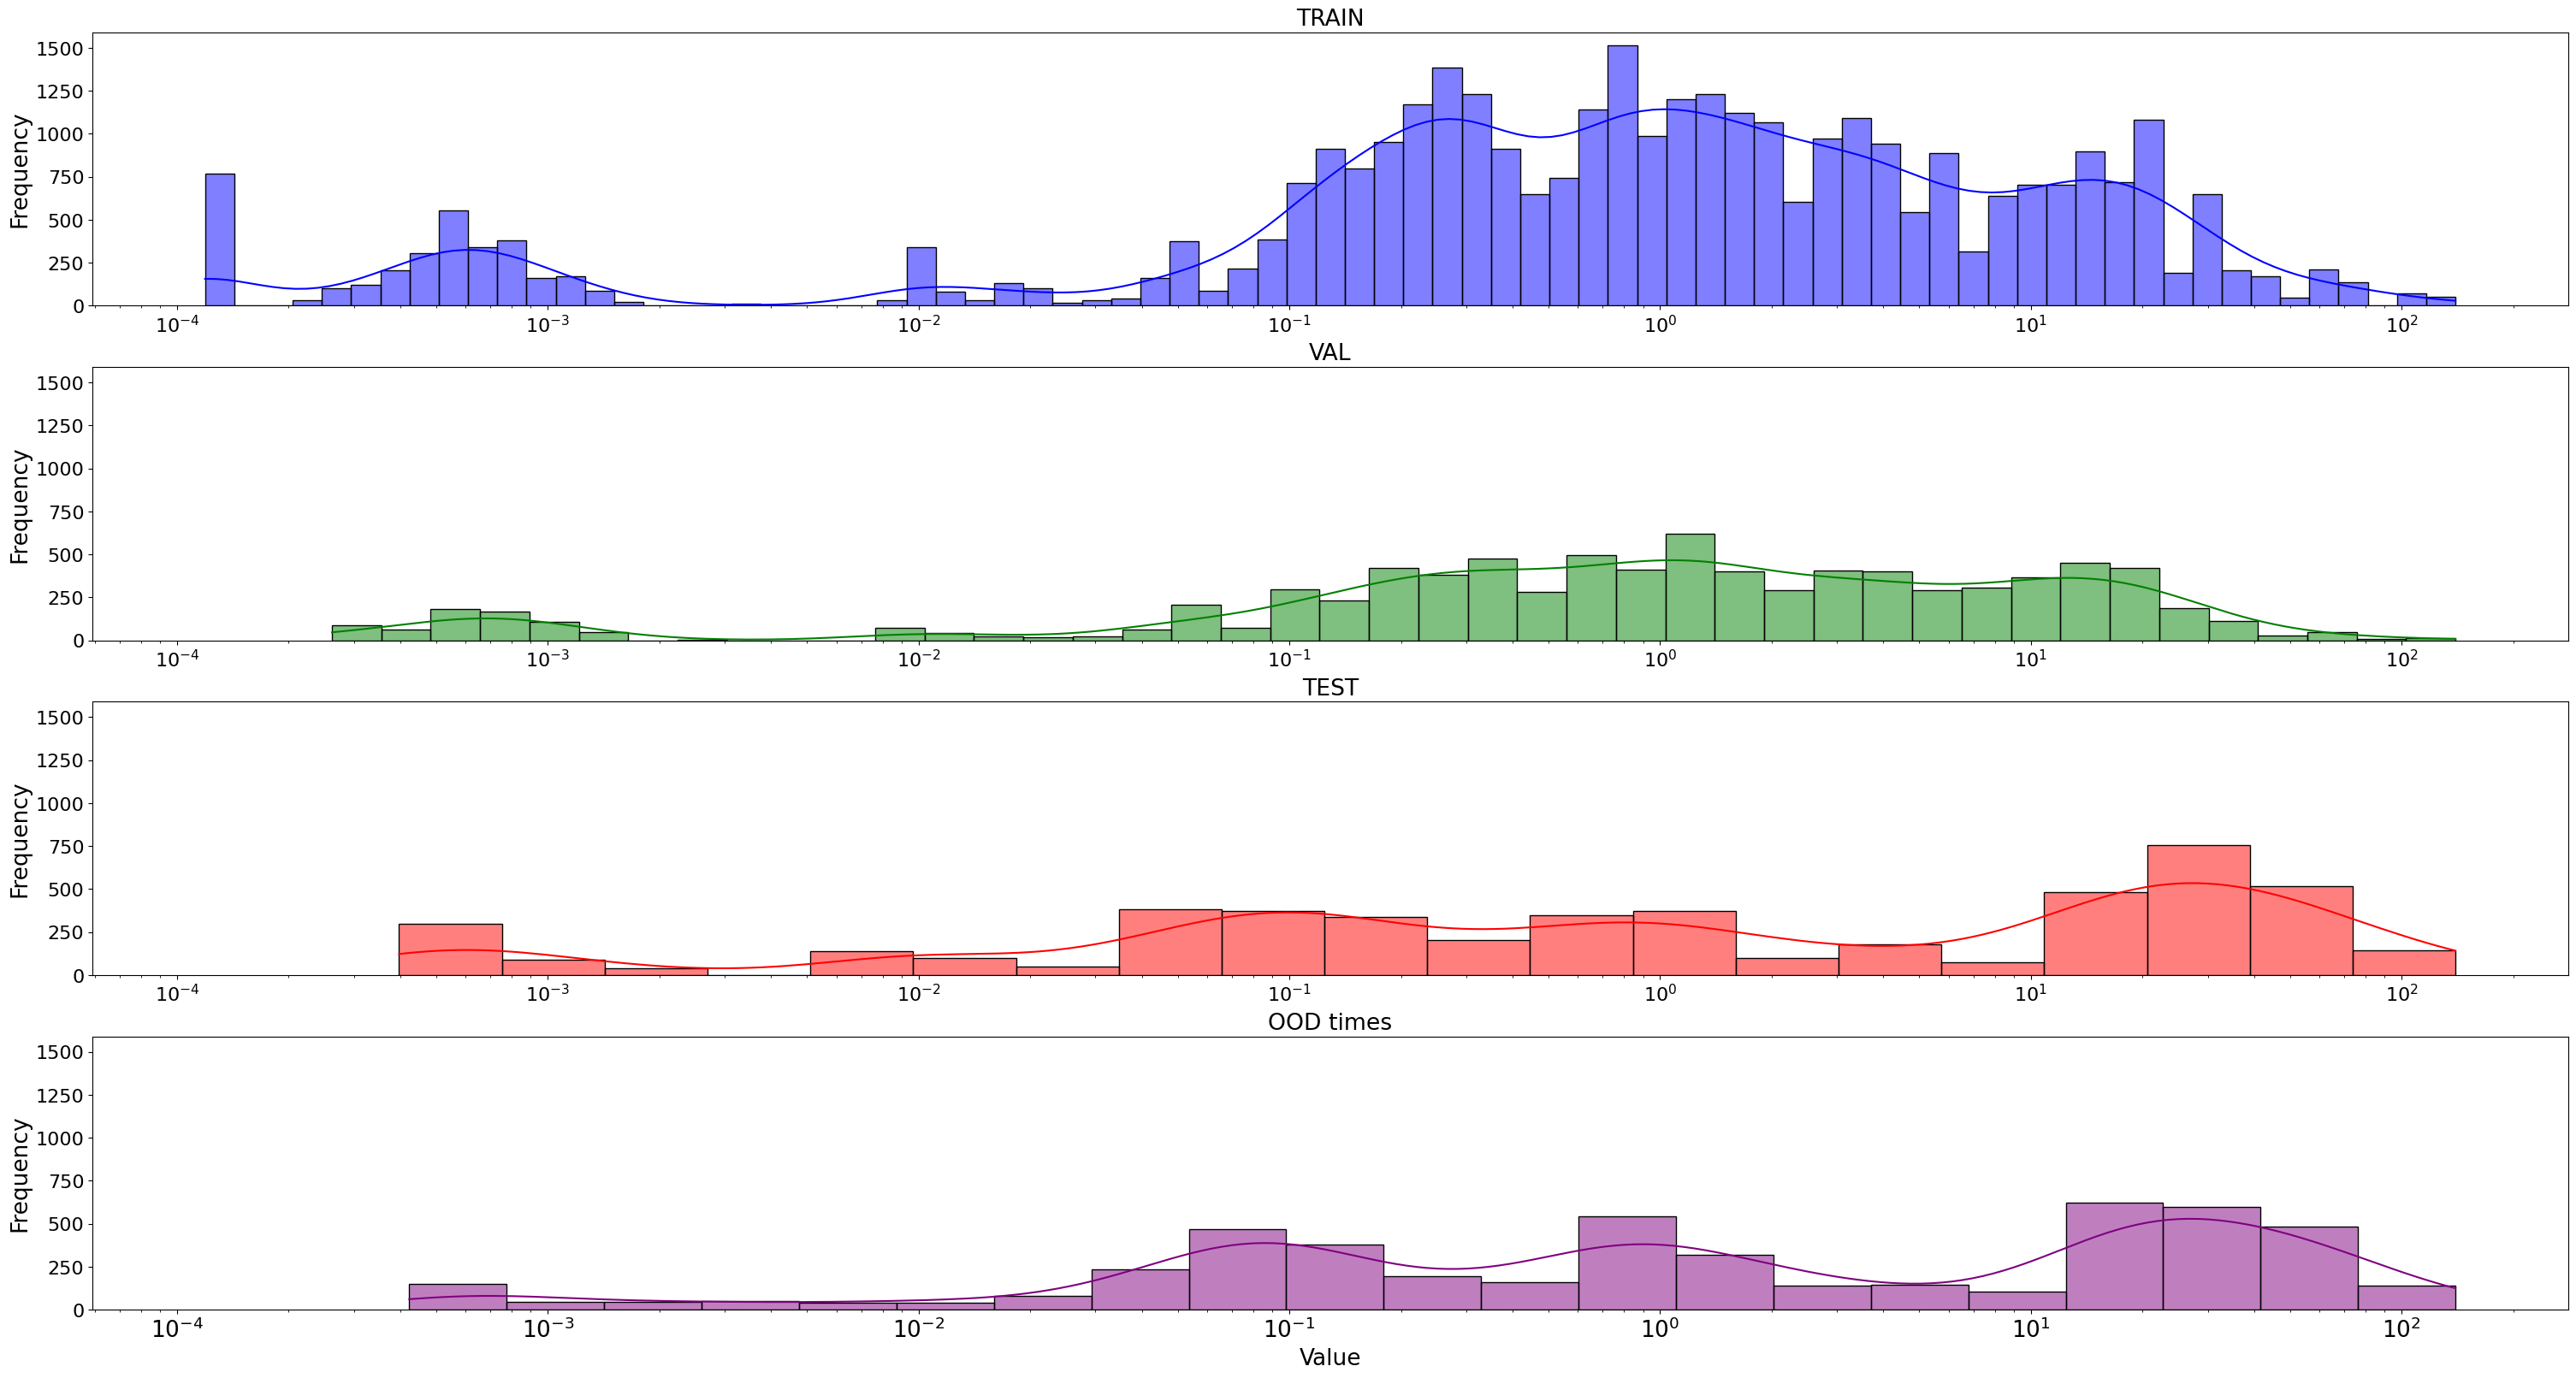

In [568]:
train_times = [el[3].to("cpu").item() for el in train_dataset for _ in range(el[2])]
val_times = [el[3].to("cpu").item() for el in val_dataset for _ in range(el[2])]

test_times = [el[3].to("cpu").item() for el in test_dataset for _ in range(el[2])]
ood_times = [el[3].to("cpu").item() for el in ood_dataset for _ in range(el[2])]

plot_times(train_times, test_times, val_times, ood_times)

# Others

Experiments looking for interesting dependencies in the rate of change of predictions or embedding when varying different channels did not show anything interesting.

In [391]:
def get_gradient_through_embedding(v, e, model):
    v = v.clone()
    v.requires_grad = True

    emb = model.btcnn(v.unsqueeze(0).to(DEVICE), e.unsqueeze(0).to(DEVICE))
    (emb @ emb.T).backward()
    nonpad_vertices = v[:, :max(e[0].flatten())+1]
    gradient = nonpad_vertices.mean(axis=1)
    
    v.grad.zero_()
    return gradient

In [338]:
def get_gradient_through_predict(v, e, model):
    v = v.clone()
    v.requires_grad = True
    
    model(v.unsqueeze(0).to(DEVICE), e.unsqueeze(0).to(DEVICE)).backward()
    nonpad_vertices = v[:, :max(e[0].flatten())+1]
    gradient = nonpad_vertices.mean(axis=1)
    
    v.grad.zero_()
    return gradient

In [392]:
gradients_through_embedding = []
for v, e, f, t in val_dataset:
    gradients_through_embedding.append(get_gradient_through_embedding(*preprocess(v, e), model))

In [339]:
gradients_through_predict = []
for v, e, f, t in val_dataset:
    gradients_through_predict.append(get_gradient_through_predict(*preprocess(v, e), model))